<h1>Taxi Demand Prediction</h1>

http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 

<h3> DATA DICTIONARY </h3>
<table>
<th>Field Name <th>Description
<tr> <td>VendorID <td>A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
<tr>
<td>tpep_pickup_datetime <td> The date and time when the meter was engaged.
<tr>
<td>tpep_dropoff_datetime <td>The date and time when the meter was disengaged.
<tr>
<td>Passenger_count <td>The number of passengers in the vehicle.
This is a driver-entered value.
<tr>
<td>Trip_distance <td>The elapsed trip distance in miles reported by the taximeter.
<tr>
<td>PULocationID <td>TLC Taxi Zone in which the taximeter was engaged
<tr><td>DOLocationID <td>TLC Taxi Zone in which the taximeter was disengaged
<tr><td>RateCodeID <td>The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride
<tr>
<td>Store_and_fwd_flag <td>This flag indicates whether the trip record was held in vehicle
memory before sending to the vendor, aka “store and forward,”
because the vehicle did not have a connection to the server.
Y= store and forward trip
N= not a store and forward trip
<tr>
<td>Payment_type <td>A numeric code signifying how the passenger paid for the trip.
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip
<tr><td>
Fare_amount <td>The time-and-distance fare calculated by the meter.
<tr><td>
Extra <td>Miscellaneous extras and surcharges. Currently, this only includes
the $0.50 and $1 rush hour and overnight charges.
<tr><td>
MTA_tax <td>$0.50 MTA tax that is automatically triggered based on the metered
rate in use.
<tr><td>
Improvement_surcharge <td>$0.30 improvement surcharge assessed trips at the flag drop. The
improvement surcharge began being levied in 2015.
<tr><td>
Tip_amount <td>Tip amount – This field is automatically populated for credit card
tips. Cash tips are not included.
<tr><td>
Tolls_amount <td>Total amount of all tolls paid in trip.
<tr><td>
Total_amount <td>The total amount charged to passengers. Does not include cash tips.
<tr><td>
Congestion_Surcharge <td>Total amount collected in trip for NYS congestion surcharge.
<tr><td>
Airport_fee <td>$1.25 for pick up only at LaGuardia and John F. Kennedy Airports
</table>

In [113]:
#Importing the required libraries
import pandas as pd
import numpy as np
import pyarrow
import fastparquet
import folium
import datetime
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
from math import ceil, floor
import pickle
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from numpy.ma import count
from numpy.core.umath import log

In [114]:
jan2021 = pd.read_parquet("C:yellow_tripdata_2021-01.parquet")

In [115]:
jan2022 = pd.read_parquet("C:yellow_tripdata_2022-01.parquet")

In [116]:
jan2021.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            98352
trip_distance                  0
RatecodeID                 98352
store_and_fwd_flag         98352
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge       98352
airport_fee              1369764
dtype: int64

In [117]:
def null_value_handled(df):
    df['airport_fee']= df['airport_fee'].fillna(0)
    df.loc[df['airport_fee'].isnull()]
    df['congestion_surcharge']= df['congestion_surcharge'].fillna(df['total_amount']-(df['fare_amount']+df['extra']+df['mta_tax']+df['tip_amount']+df['tolls_amount']+df['improvement_surcharge']))
    df=df.drop('store_and_fwd_flag',axis=1)
    average=df['total_amount']/df['trip_distance']
    mean=np.mean(average[np.isfinite(average)])
    df['passenger_count']= df['passenger_count'].fillna(0)
    df['RatecodeID']= df['RatecodeID'].fillna(0)
    return(df)

In [118]:
jan2021 = null_value_handled(jan2021)

In [119]:
jan2021.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

## Cleaning the data

Finding outliers based on quartiles and percentiles, also need to remove error values. We will proceed feature by feature

## Finding trip durations

In [120]:
def convert_to_unix(s):
    # return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
    return (s- np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')

We create a function to calculate the trip duration, speed and create a new data frame that only uses the required attributes

In [121]:
def calc_trip_times(df):

    duration = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
# pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
# calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    # append durations of trips and speed in miles/hr to a new dataframe
    new_frame = df[['passenger_count', 'trip_distance', 'PULocationID','DOLocationID','total_amount']].copy()
    new_frame['trip_time'] = durations
    new_frame['pickup_times']= duration_pickup
    #Not putting speed until we remove the 0 trip duration values
    new_frame['Speed'] = 60 *(new_frame['trip_distance']/new_frame['trip_time'])
    
    return new_frame

In [122]:
jan2021_with_durations = calc_trip_times(jan2021)

In [123]:
#removing all outliers based on our univariate analysis above
#Without speed
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    
    temp_frame = new_frame[(new_frame.trip_time > 0) & (new_frame.trip_time < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 29)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    #temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    #e = temp_frame.shape[0]
    #print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    new_frame = new_frame[(new_frame.trip_time > 0) & (new_frame.trip_time < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed "+ str(a - new_frame.shape[0]))
    print ("---")
    return new_frame

In [124]:
jan2021_with_durations.isna().sum()

passenger_count      0
trip_distance        0
PULocationID         0
DOLocationID         0
total_amount         0
trip_time            0
pickup_times         0
Speed              709
dtype: int64

In [125]:
jan2021_with_durations = remove_outliers(jan2021_with_durations)

Number of outliers from trip times analysis: 8834
Number of outliers from trip distance analysis: 21274
Number of outliers from fare analysis: 7118
Total outliers removed 41638
---


In [126]:
jan2021_with_durations.isna().sum()

passenger_count    0
trip_distance      0
PULocationID       0
DOLocationID       0
total_amount       0
trip_time          0
pickup_times       0
Speed              0
dtype: int64

## Making region clusters

In [127]:
oldcol  = jan2021_with_durations['PULocationID'].values.reshape(-1,1)

In [128]:
def binning (df) : 
    bins  = ceil(1+3.322*log(count(df['PULocationID'])))
    oldcol  = df['PULocationID'].values.reshape(-1,1)
    kmeans = KMeans(n_clusters=int(bins),  random_state=0).fit(oldcol)
    newcol = kmeans.predict(oldcol)
    df['PUCluster'] = newcol
    return df

In [129]:
jan2021_with_durations = binning(jan2021_with_durations)

In [130]:
jan2021_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0           2.10           142            43         11.80   
1              1.0           0.20           238           151          4.30   
2              1.0          14.70           132           165         51.95   
3              0.0          10.60           138           132         36.35   
4              1.0           4.94            68            33         24.36   

   trip_time  pickup_times      Speed  PUCluster  
0   6.033333  1.609461e+09  20.883978         44  
1   0.983333  1.609462e+09  12.203390         27  
2  27.600000  1.609462e+09  31.956522         26  
3  15.216667  1.609460e+09  41.796276          4  
4  16.533333  1.609461e+09  17.927419          5

In [131]:
bins  = ceil(1+3.322*log(count(jan2021_with_durations['PULocationID'])))
kmeans = KMeans(n_clusters=int(bins),  random_state=0).fit(oldcol)
jan2021_with_durations['PUCluster'] = kmeans.predict(oldcol)
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

In [132]:
cluster_centers

array([[ 90.14115229],
       [237.        ],
       [161.47960281],
       [ 40.78497224],
       [137.35118092],
       [ 68.15276961],
       [262.74146188],
       [186.04361082],
       [128.93316029],
       [106.99904328],
       [ 13.56478602],
       [203.56052899],
       [249.1642912 ],
       [229.37441603],
       [140.52516794],
       [ 74.68510627],
       [170.05034603],
       [210.71706635],
       [151.08545322],
       [ 50.33276788],
       [ 99.86569324],
       [ 24.13256579],
       [113.65668247],
       [245.56682447],
       [233.6655903 ],
       [ 48.00134113],
       [132.01083774],
       [238.        ],
       [ 79.07485961],
       [163.43769981],
       [224.57923679],
       [  5.77090191],
       [ 34.63917852],
       [143.29236796],
       [124.63435058],
       [ 42.92425617],
       [194.79798422],
       [231.10114   ],
       [157.88978819],
       [ 60.88480392],
       [ 87.22038678],
       [147.67394763],
       [179.66994267],
       [239

In [133]:
print(cluster_len)

48


## Time binning

In [134]:
#Finding unix time for jan, feb and march in 2021 and 2022

In [135]:
tjan21 = convert_to_unix(np.datetime64('2021-01-01T00:00:00Z'))
tjan22 = convert_to_unix(np.datetime64('2022-01-01T00:00:00Z'))
tfeb21= convert_to_unix(np.datetime64('2021-02-01T00:00:00Z'))
tfeb22= convert_to_unix(np.datetime64('2022-02-01T00:00:00Z'))
tmar21= convert_to_unix(np.datetime64('2021-03-01T00:00:00Z'))
tmar22= convert_to_unix(np.datetime64('2022-03-01T00:00:00Z'))
unix_times = [[tjan21,tfeb21,tmar21],[tjan22,tfeb22,tmar22]]
print(unix_times)

[[1609459200.0, 1612137600.0, 1614556800.0], [1640995200.0, 1643673600.0, 1646092800.0]]


In [136]:
def add_pickup_bins(frame,month, year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
 
    start_pickup_unix=unix_times[year-1][ month-1]

    frame['pickup_bins'] = np.array(start_pickup_unix)
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [137]:
jan2021_with_durations = add_pickup_bins(jan2021_with_durations, 1, 1)

In [138]:
jan2021_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0           2.10           142            43         11.80   
1              1.0           0.20           238           151          4.30   
2              1.0          14.70           132           165         51.95   
3              0.0          10.60           138           132         36.35   
4              1.0           4.94            68            33         24.36   

   trip_time  pickup_times      Speed  PUCluster  pickup_bins  
0   6.033333  1.609461e+09  20.883978         44           36  
1   0.983333  1.609462e+09  12.203390         27           38  
2  27.600000  1.609462e+09  31.956522         26           37  
3  15.216667  1.609460e+09  41.796276          4           34  
4  16.533333  1.609461e+09  17.927419          5           36

In [139]:
jan_2021_groupby = jan2021_with_durations[['PUCluster','pickup_bins','trip_distance']].groupby(['PUCluster','pickup_bins']).count()

In [140]:
jan_2021_groupby.head()

trip_distance
PUCluster pickup_bins               
0         33                       5
          34                       2
          35                       2
          36                       2
          37                       6

In [141]:
len(jan_2021_groupby)

153234

## Defining a data prepping function

In [142]:
def dataprep(df,month, year):
    new_df = null_value_handled(df)
    new_df = calc_trip_times(new_df)
    new_df = remove_outliers(new_df)
    new_df = binning(new_df)
    new_df = add_pickup_bins(new_df, month, year)
    new_df_groupby = new_df[['PUCluster','pickup_bins','trip_distance']].groupby(['PUCluster','pickup_bins']).count()
    return new_df, new_df_groupby

In [143]:
jan2022_with_durations, jan_2022_groupby = dataprep(jan2022,1,2)

Number of outliers from trip times analysis: 4955
Number of outliers from trip distance analysis: 31637
Number of outliers from fare analysis: 13409
Total outliers removed 57306
---


In [144]:
feb2022 = pd.read_parquet("C:yellow_tripdata_2022-02.parquet")

In [145]:
feb2022_with_durations, feb_2022_groupby = dataprep(feb2022,2,2)

Number of outliers from trip times analysis: 5986
Number of outliers from trip distance analysis: 34624
Number of outliers from fare analysis: 16191
Total outliers removed 63525
---


In [146]:
mar2022 = pd.read_parquet("C:yellow_tripdata_2022-03.parquet")

In [147]:
mar2022_with_durations, mar_2022_groupby = dataprep(mar2022,3,2)

Number of outliers from trip times analysis: 6844
Number of outliers from trip distance analysis: 44618
Number of outliers from fare analysis: 20740
Total outliers removed 81566
---


In [148]:
jan2022_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              2.0           3.80           142           236         21.95   
1              1.0           2.10           236            42         13.30   
2              1.0           0.97           166           166         10.56   
3              1.0           1.09           114            68         11.80   
4              1.0           4.30            68           163         30.30   

   trip_time  pickup_times      Speed  PUCluster  pickup_bins  
0  17.816667  1.640997e+09  12.797007         28           36  
1   8.400000  1.640997e+09  15.000000         40           36  
2   8.966667  1.640998e+09   6.490706         29           38  
3  10.033333  1.640997e+09   6.518272         19           35  
4  37.533333  1.640997e+09   6.873890         15           36

In [149]:
jan_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         31                       1
          33                       9
          34                      20
          35                      16
          36                      27

In [150]:
feb2022_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0           5.40           138           252         23.45   
1              1.0           6.40           138            41         30.10   
2              1.0          12.50           138           200         44.60   
3              1.0           9.88           239           200         34.80   
4              1.0          12.16           138           125         48.66   

   trip_time  pickup_times      Speed  PUCluster  pickup_bins  
0  12.433333  1.643674e+09  26.058981         43           33  
1  17.550000  1.643676e+09  21.880342         43           36  
2  23.650000  1.643674e+09  31.712474         43           33  
3  20.083333  1.643674e+09  29.517012         44           33  
4  26.316667  1.643674e+09  27.723876         43           33

In [151]:
mar2022_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0           2.40            90           209         13.80   
1              1.0           2.20           148           234         14.30   
2              1.0          19.78           132           249         67.61   
3              2.0           2.94           211            66         19.24   
4              1.0           8.57           138           197         33.06   

   trip_time  pickup_times      Speed  PUCluster  pickup_bins  
0  11.450000  1.646094e+09  12.576419         16           34  
1  12.266667  1.646096e+09  10.760870         28           37  
2  43.950000  1.646093e+09  27.003413          3           33  
3  10.950000  1.646096e+09  16.109589         11           38  
4  18.633333  1.646094e+09  27.595707         23           34

In [152]:
feb_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         34                       1
          35                       2
          36                       1
          37                       3
          39                       3

In [153]:
mar_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         33                       9
          34                       8
          35                       1
          37                       4
          38                       3

## Smoothening 

In [154]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,cluster_len):
        new = frame[frame['PUCluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [155]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2021_unique = return_unq_pickup_bins(jan2021_with_durations)
jan_2022_unique = return_unq_pickup_bins(jan2022_with_durations)

#feb
feb_2022_unique = return_unq_pickup_bins(feb2022_with_durations)
#March
mar_2022_unique = return_unq_pickup_bins(mar2022_with_durations)

In [156]:
for i in range(48):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2021_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  660
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  807
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  605
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  1254
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  555
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  462
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  376
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  325
----

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [157]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values, month):
    smoothed_regions=[]
    ind=0
    for r in range(0,cluster_len):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [158]:
jan2022_fill = fill_missing(jan_2022_groupby['trip_distance'].values,jan_2022_unique,1)

In [159]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,48):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [160]:
#Filling Missing values of Jan-2021 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2021_fill = fill_missing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)

#Smoothing Missing values of Jan-2021
jan_2021_smooth = smoothing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)

TypeError: fill_missing() missing 1 required positional argument: 'month'

In [ ]:
# number of 10min indices for jan 2021= 24*31*60/10 = 4464
# number of 10min indices for jan 2022 = 24*31*60/10 = 4464
# number of 10min indices for feb 2022 = 24*28*60/10 = 4032
# number of 10min indices for march 2022 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2021_fill))

number of 10min intravels among all the clusters  214272


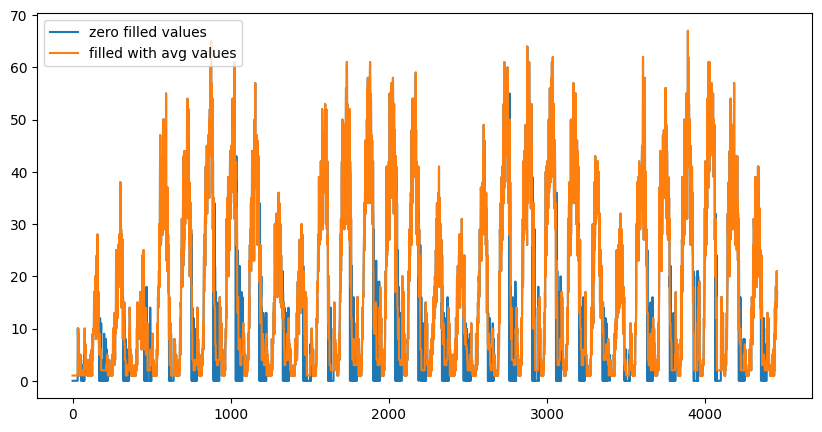

In [ ]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2021_fill[4464:8920], label="zero filled values")
plt.plot(jan_2021_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [ ]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
# 10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 20 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 10, 0, 0, 20
# where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.

In [ ]:
jan_2021_smooth = smoothing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)
jan_2022_smooth = fill_missing(jan_2022_groupby['trip_distance'].values,jan_2022_unique)
feb_2022_smooth = fill_missing(feb_2022_groupby['trip_distance'].values,feb_2022_unique)
mar_2022_smooth = fill_missing(mar_2022_groupby['trip_distance'].values,mar_2022_unique)

In [ ]:
# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2021= 24*31*60/10 = 4464
# number of 10min indices for jan 2022 = 24*31*60/10 = 4464
# number of 10min indices for feb 2022 = 24*28*60/10 = 4032
# number of 10min indices for march 2022 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4032+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,48):
    regions_cum.append(jan_2022_smooth[4464*i:4464*(i+1)]+feb_2022_smooth[4032*i:4032*(i+1)]+mar_2022_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))

print(len(regions_cum[0]))



48
12960


## Time series and Fourier Transforms

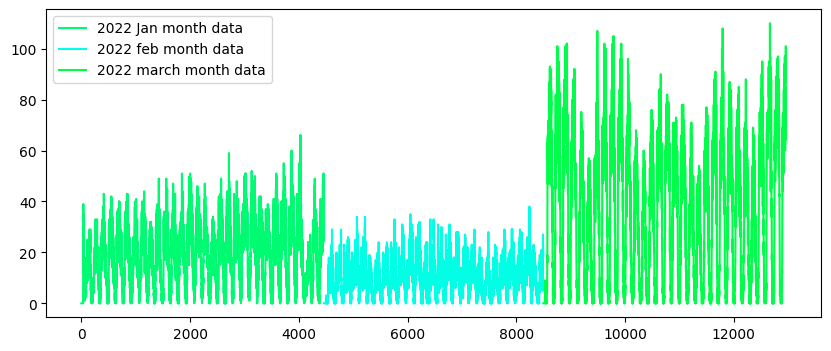

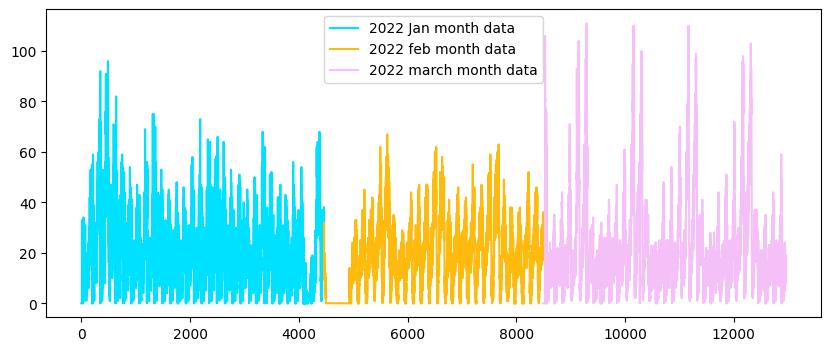

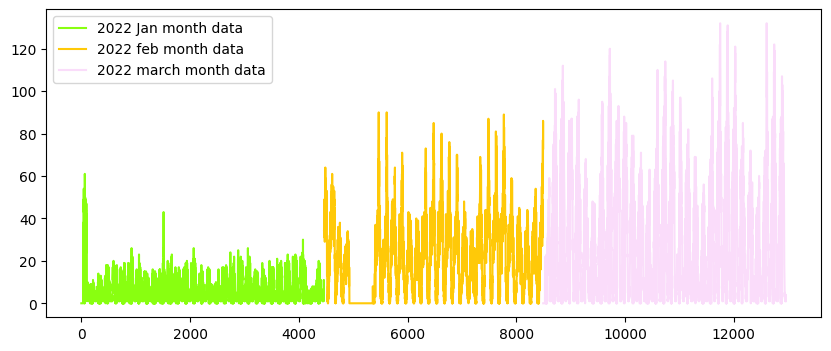

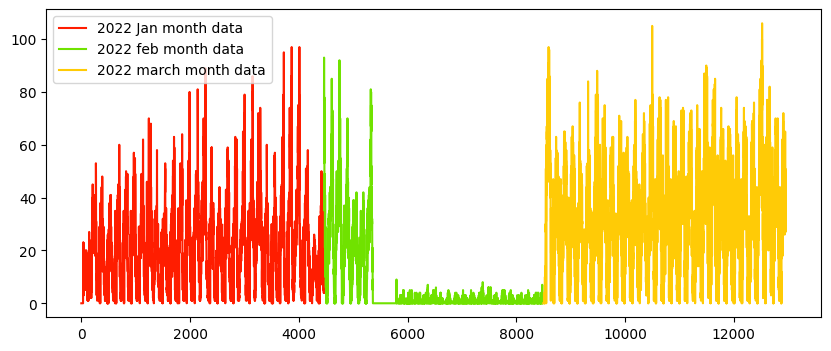

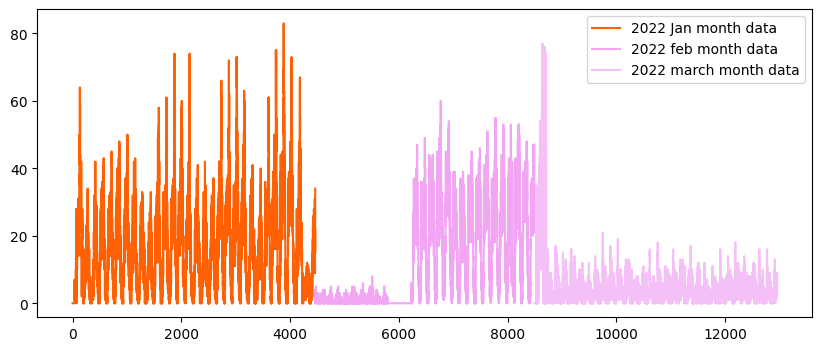

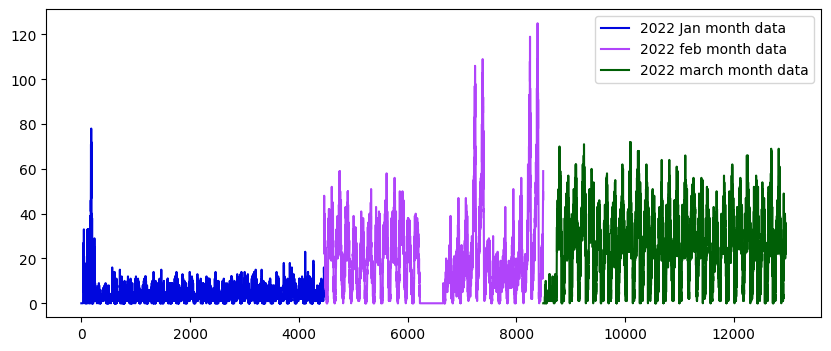

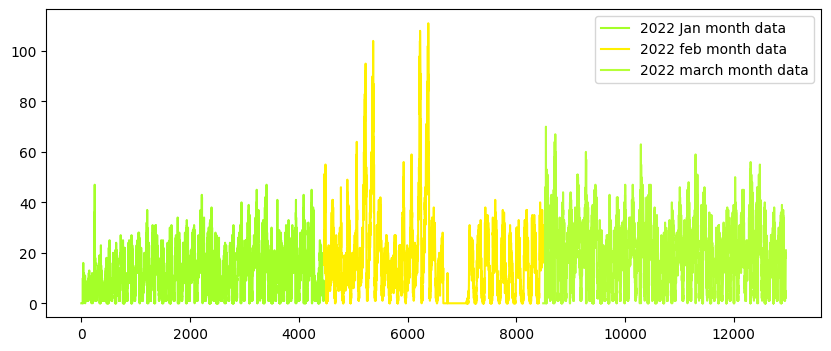

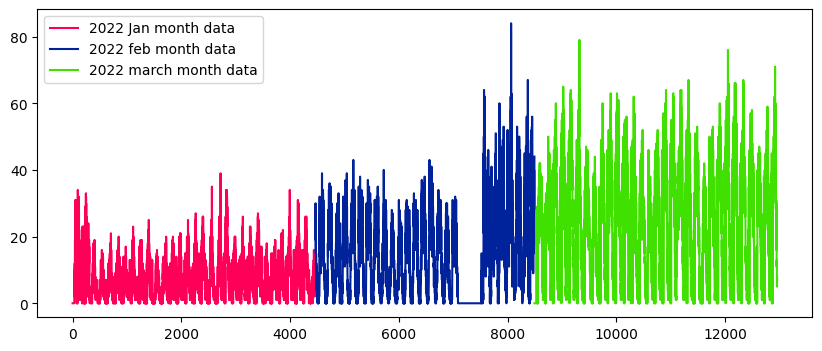

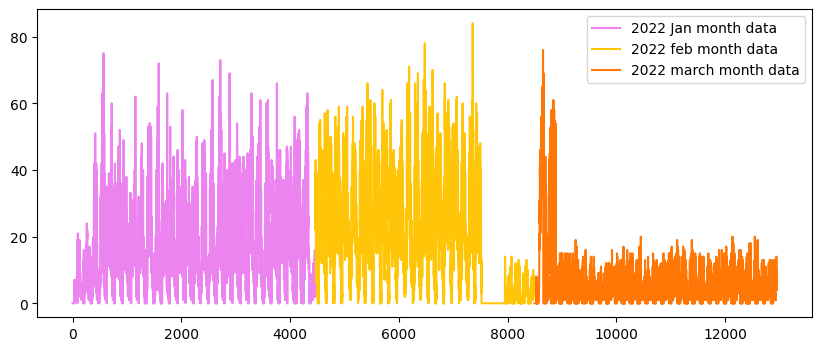

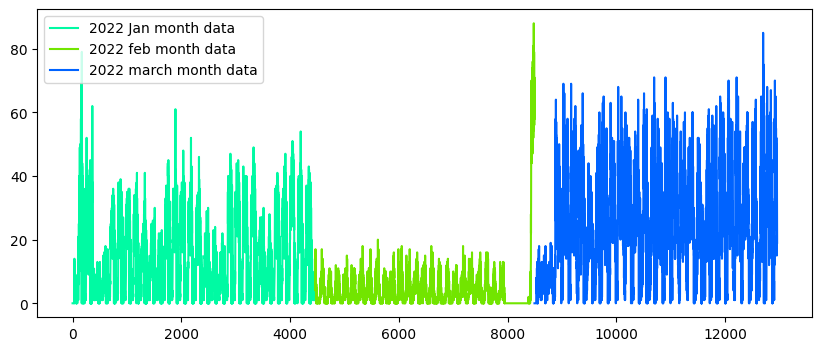

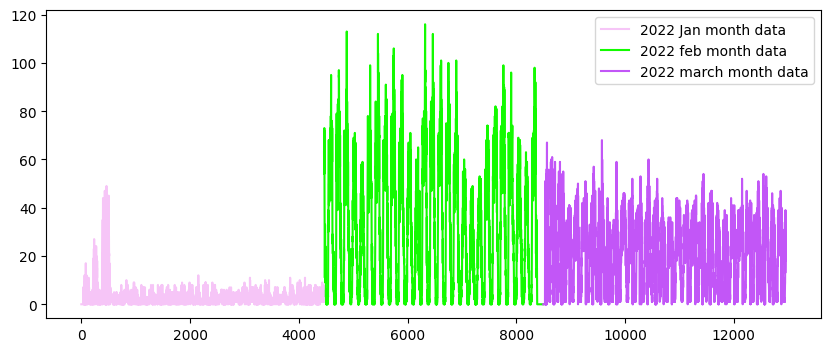

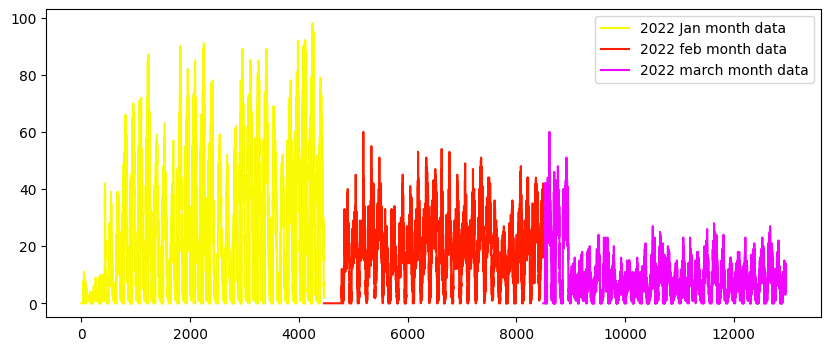

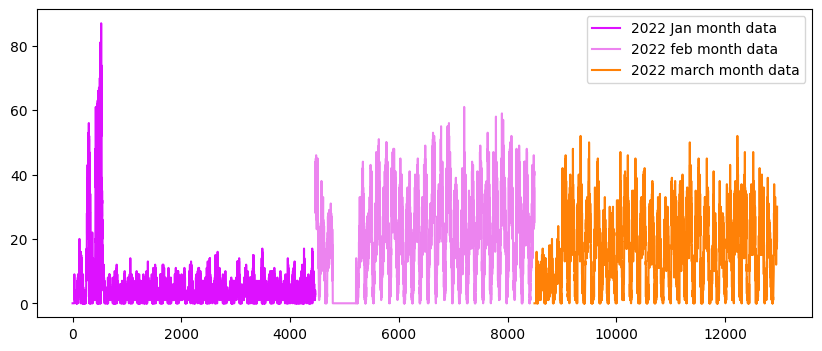

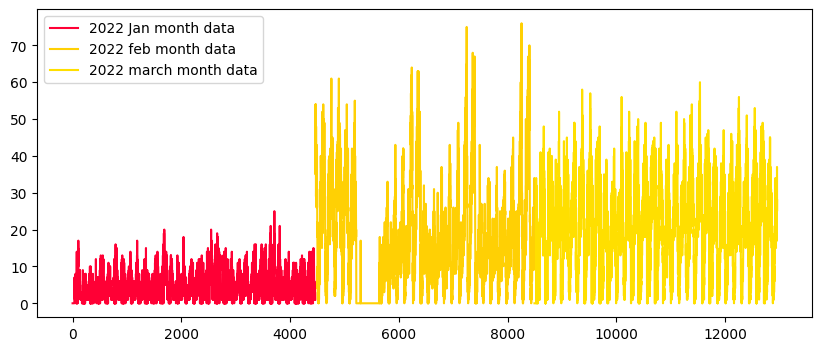

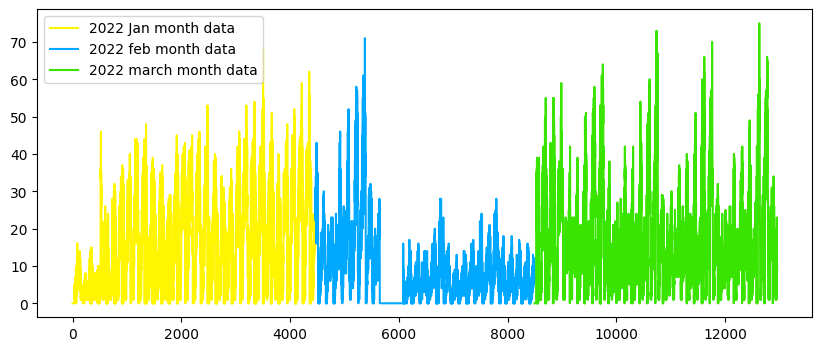

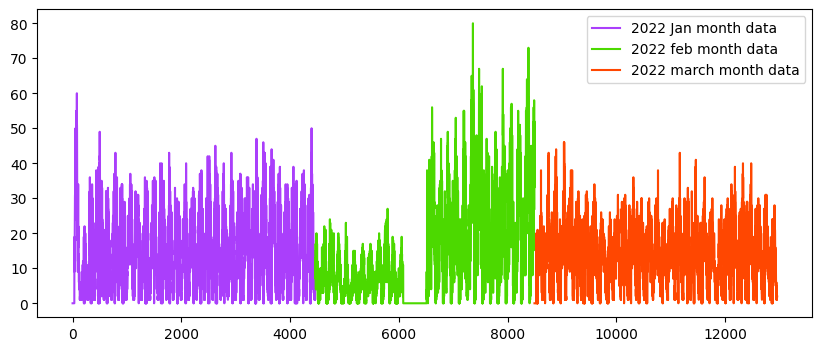

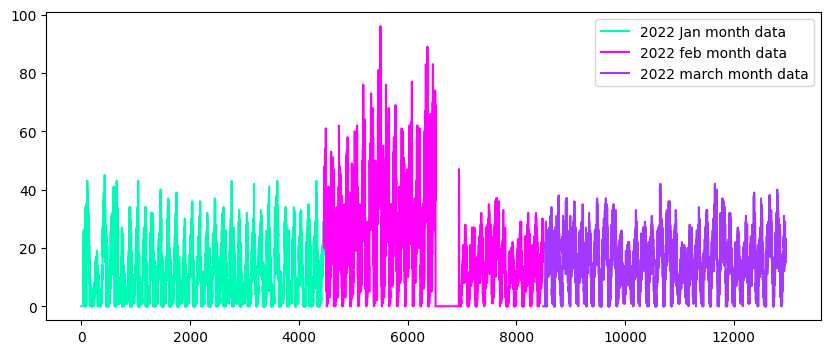

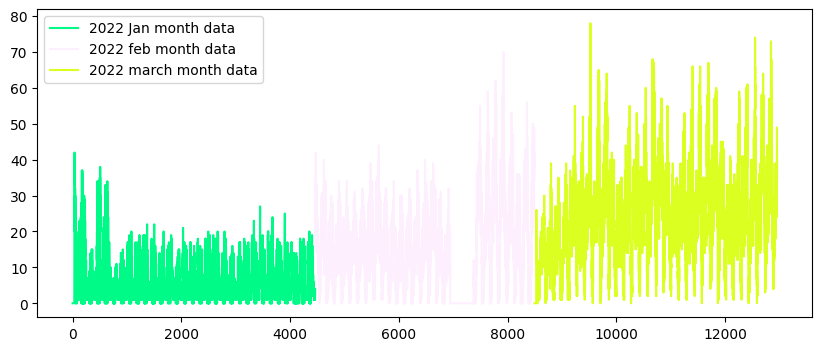

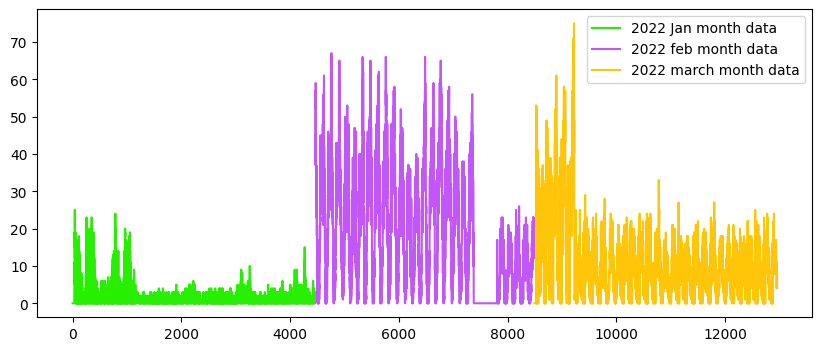

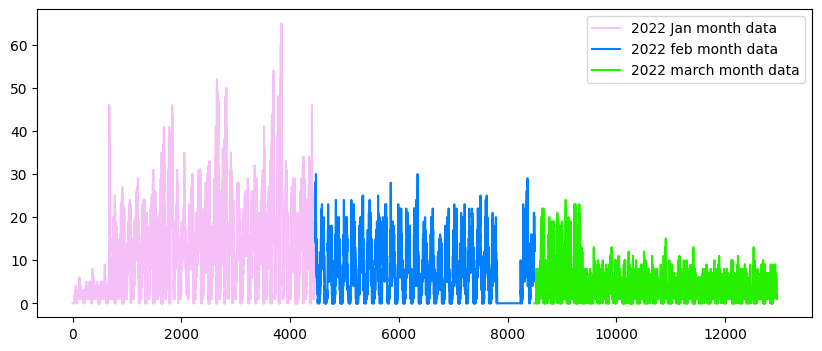

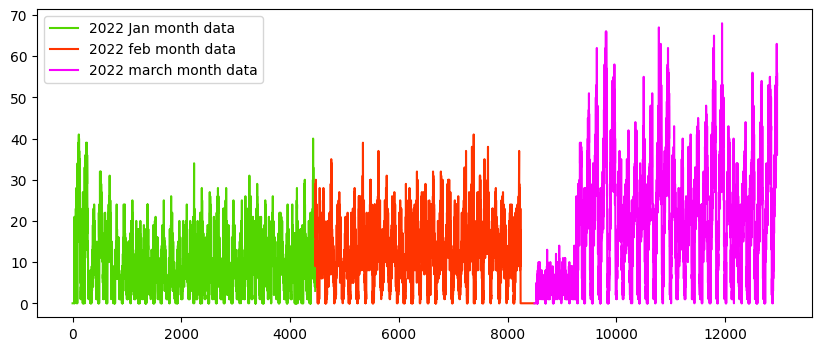

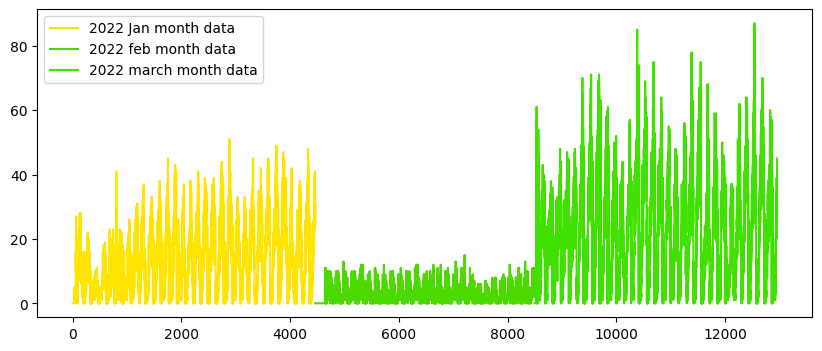

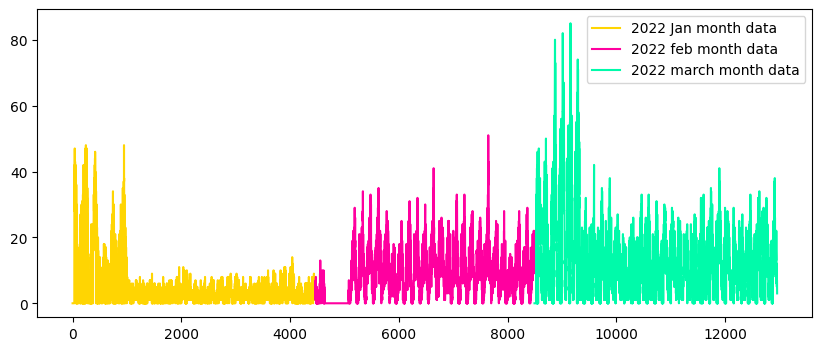

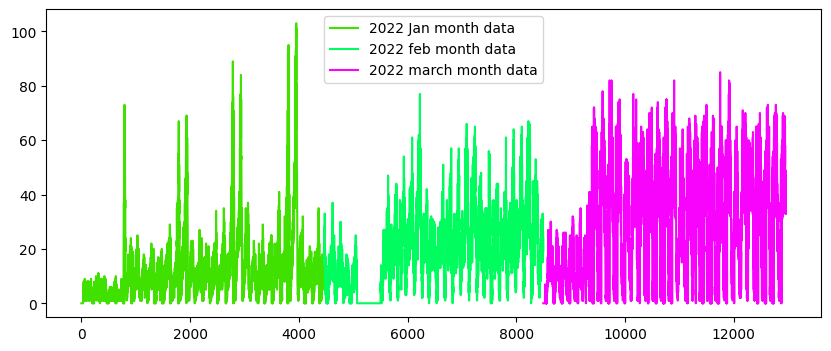

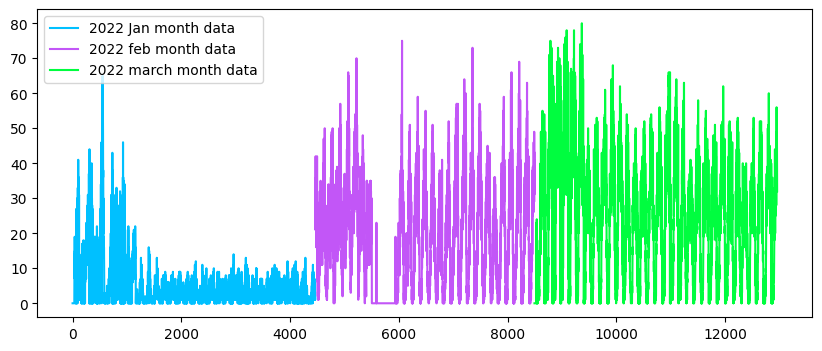

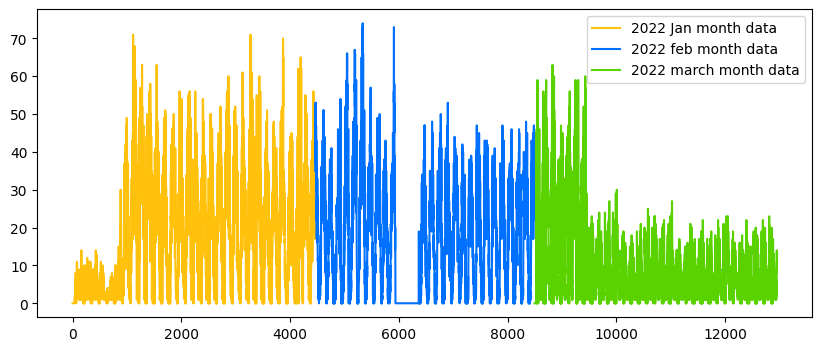

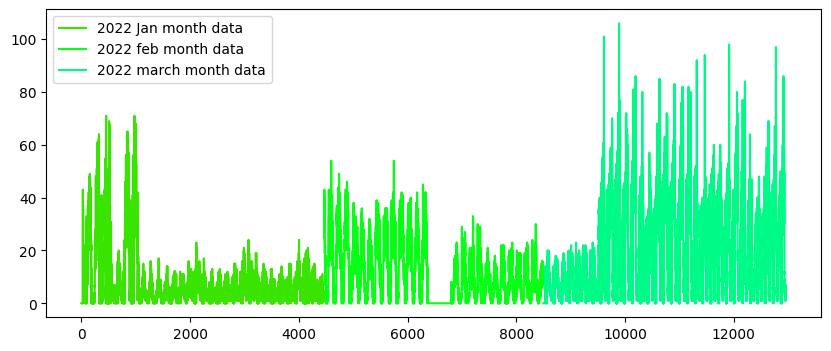

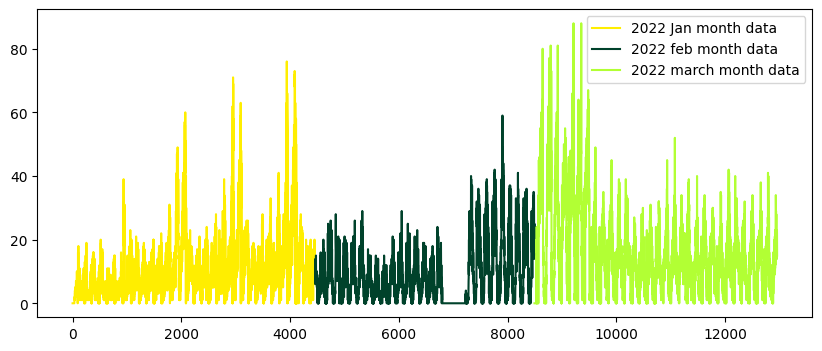

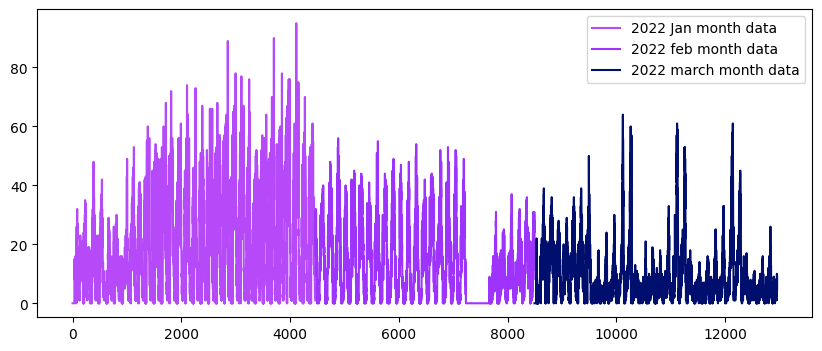

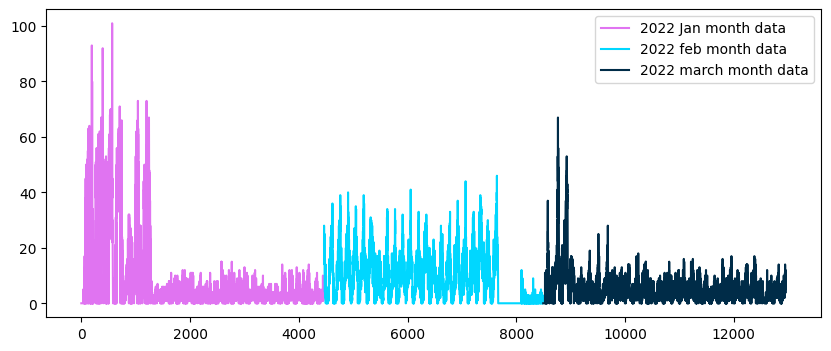

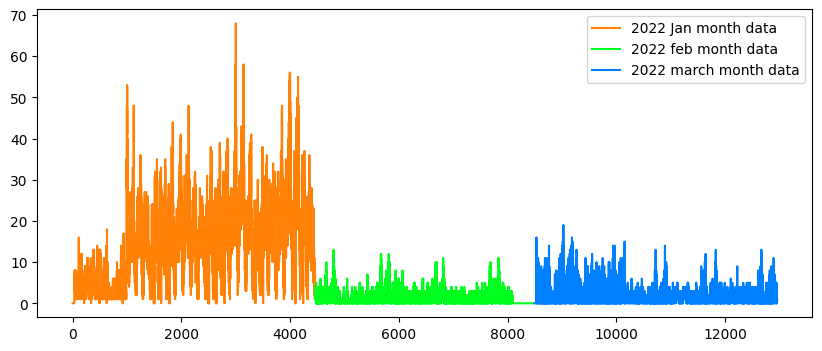

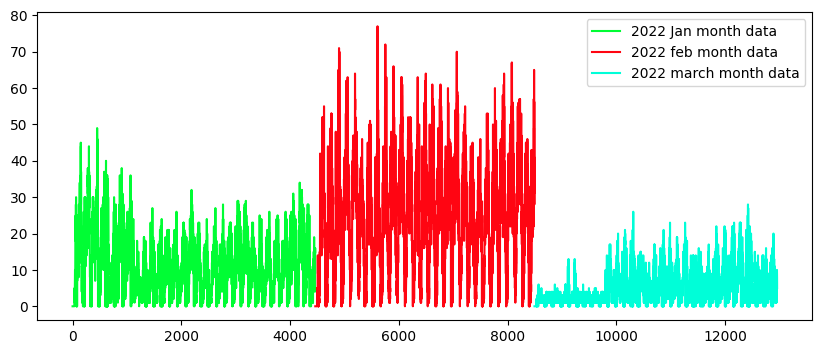

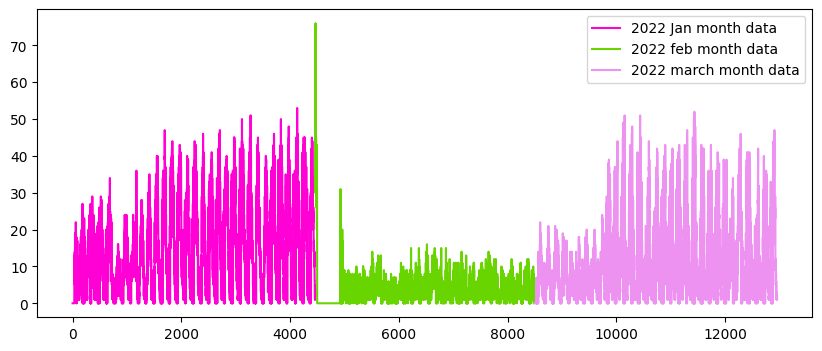

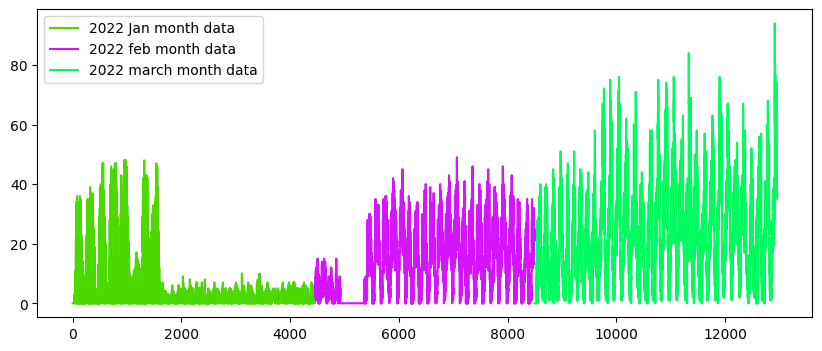

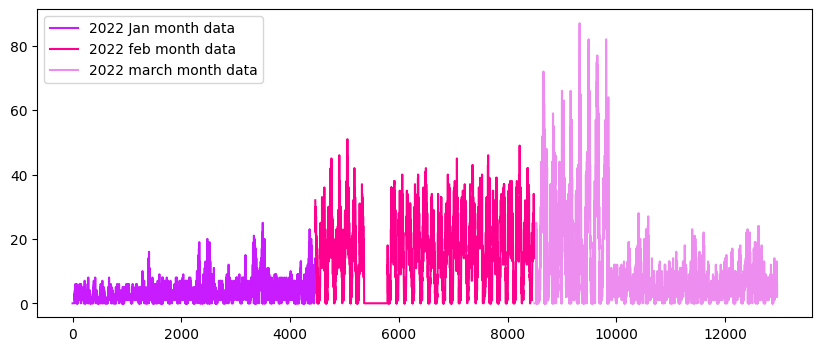

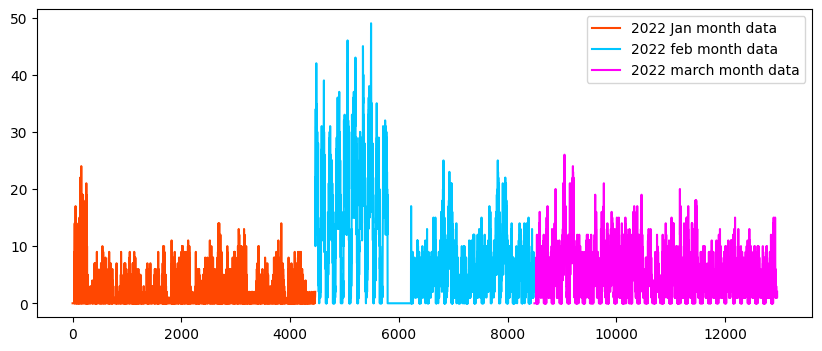

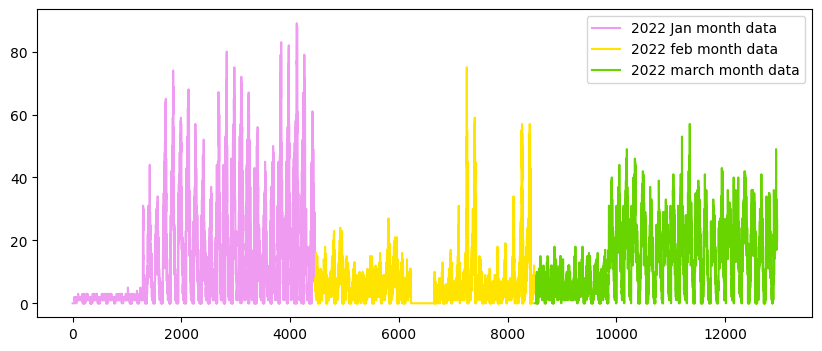

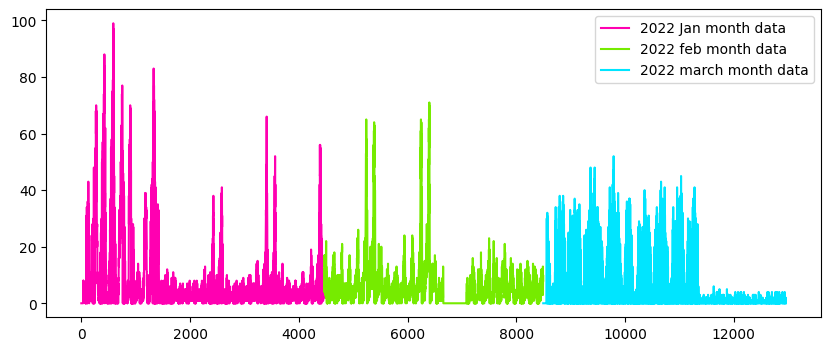

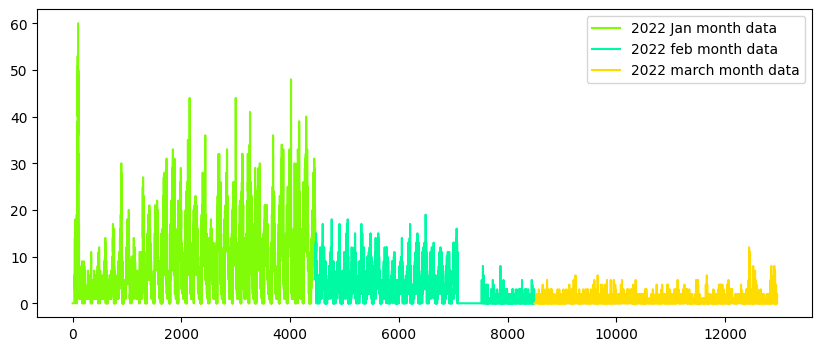

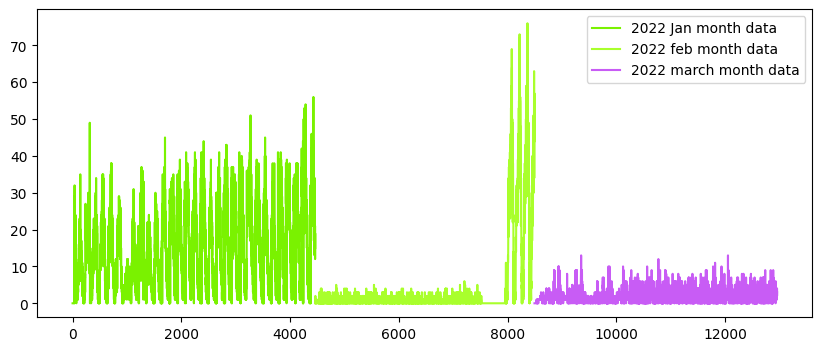

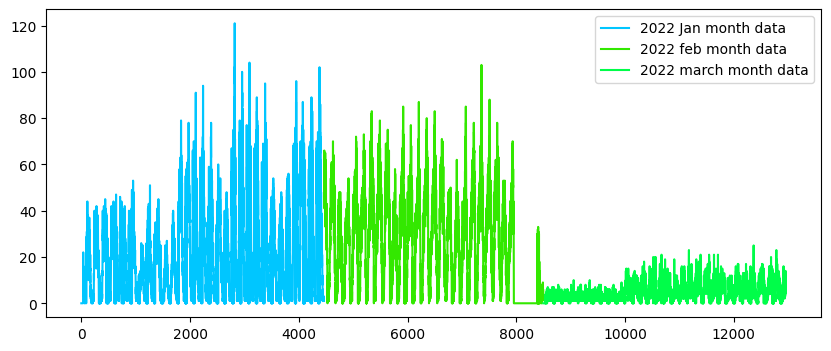

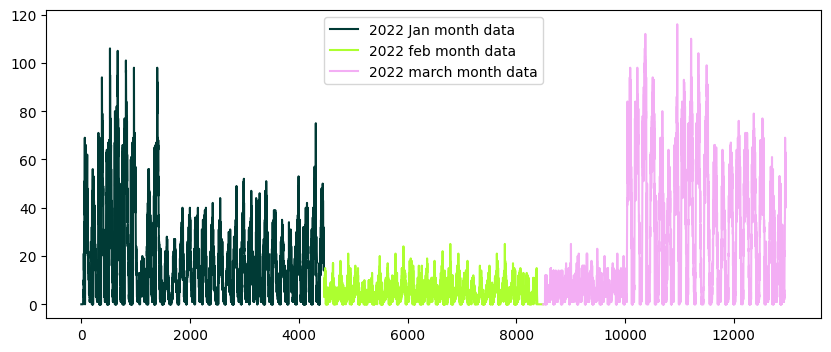

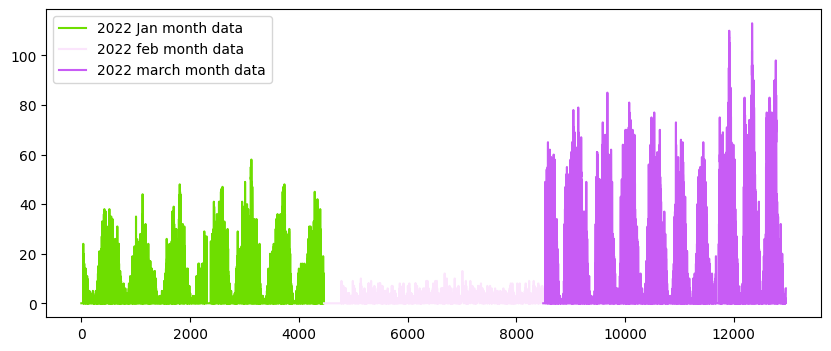

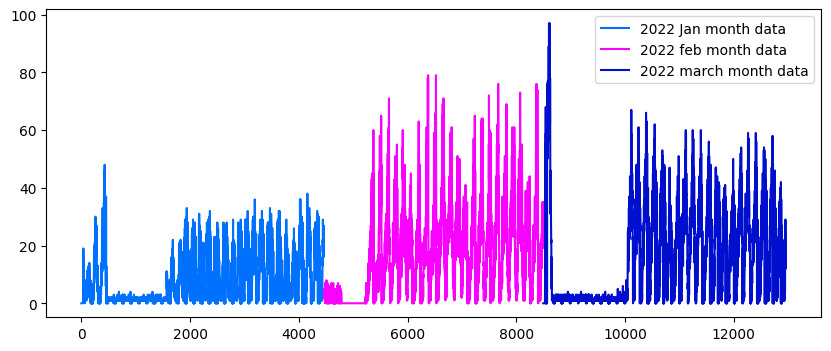

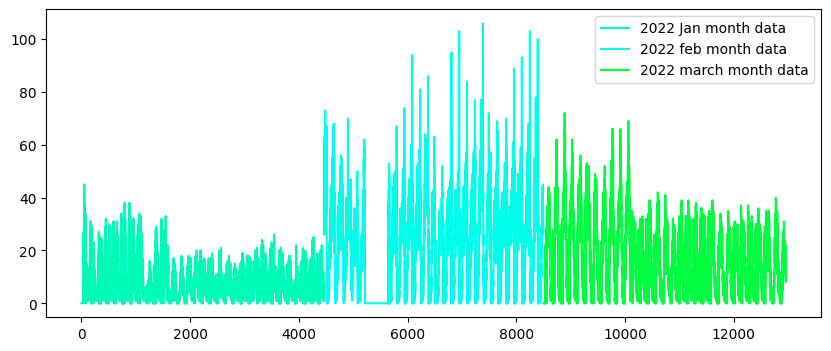

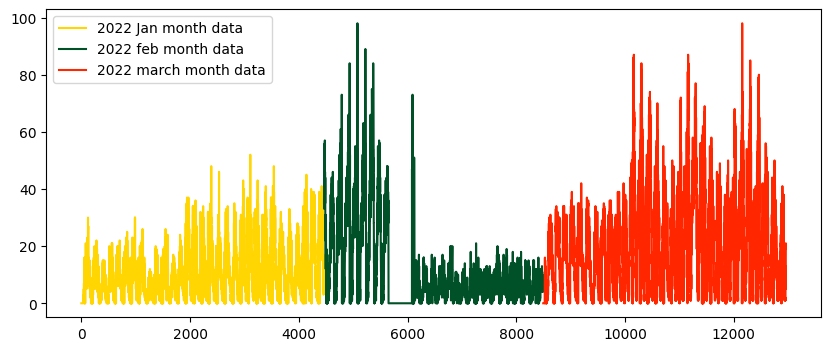

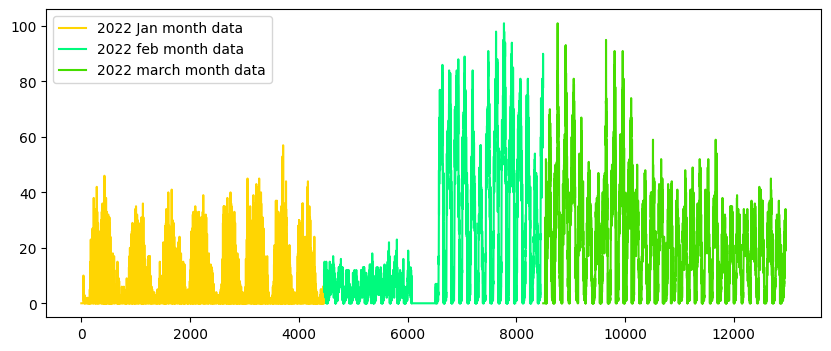

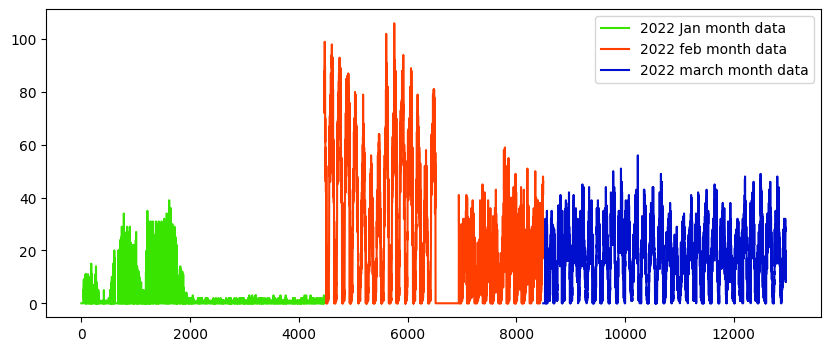

In [ ]:
def uniqueish_color():
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8496))
third_x = list(range(8496,12960))
for i in range(48):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2022 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8496], color=uniqueish_color(), label='2022 feb month data')
    plt.plot(third_x,regions_cum[i][8496:], color=uniqueish_color(), label='2022 march month data')
    plt.legend()
    plt.show()

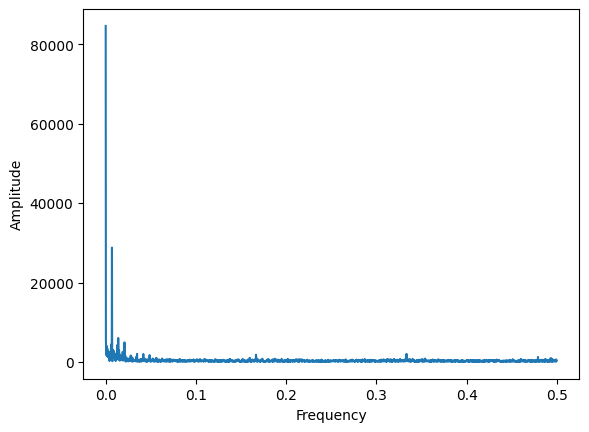

In [ ]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2022_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
#Preparing the Dataframe only with x(i) values as jan-2021 data and y(i) values as jan-2022
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2021_fill
ratios_jan['2022']=jan_2022_smooth
ratios_jan['Ratios']=ratios_jan['2022']*1.0/ratios_jan['Given']*1.0

In [ ]:
ratios_jan = ratios_jan[ratios_jan['Given'] > 0]
ratios_jan = ratios_jan[ratios_jan['2022']>0]

In [ ]:
ratios_jan.head()

Given  2022  Ratios
33      5     9     1.8
34      2    20    10.0
35      2    16     8.0
36      2    27    13.5
37      6    39     6.5

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [ ]:
def moving_averages_ratios(r, n):
    ratios = r.copy()
    lab = 'SMA'+str(n)
    ratios[lab] = ratios['Ratios'].rolling(n).mean()
    ratios['Pred'] = ratios[lab] * ratios['Given']
    ratios['AbsError'] = abs(ratios['Pred'] - ratios['2022'])
    #print(ratios.loc[ratios['Pred'] == 0])
    ratios['mae'] = ratios['AbsError']/ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['Ratios', lab]].plot(label='Ratios',figsize=(16, 8))
    mape = ratios['mae'].mean()
    mse = ratios['se'].sum()/len(ratios['se'])
    print(ratios.head())
    
    #Plotting the moving averages
    
    return mape, mse

    Given  2022    Ratios      SMA5       Pred   AbsError       mae  \
37      6    39  6.500000  7.960000  47.760000   8.760000  0.224615   
38      5    31  6.200000  8.840000  44.200000  13.200000  0.425806   
39      3    28  9.333333  8.706667  26.120000   1.880000  0.067143   
40     10    29  2.900000  7.686667  76.866667  47.866667  1.650575   
41      5    33  6.600000  6.306667  31.533333   1.466667  0.044444   

             se  
37    76.737600  
38   174.240000  
39     3.534400  
40  2291.217778  
41     2.151111  
Mean Absolute Percentage Error: 0.6558840652854059
Mean Square Error: 131.54817552148424
Root Mean Square Error: 11.46944530138595
    Given  2022    Ratios     SMA10       Pred   AbsError       mae  \
42      6    33  5.500000  7.033333  42.200000   9.200000  0.278788   
43      4    35  8.750000  7.728333  30.913333   4.086667  0.116762   
44      5    19  3.800000  7.108333  35.541667  16.541667  0.870614   
45      4    17  4.250000  6.733333  26.933333   9

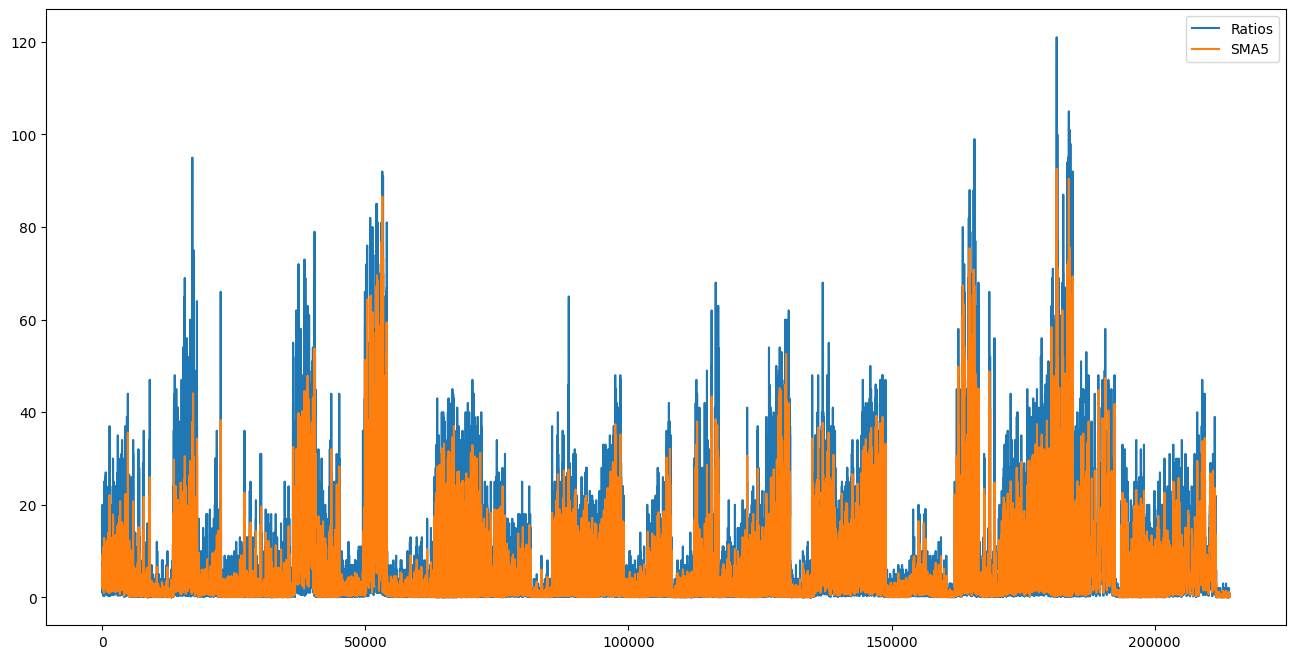

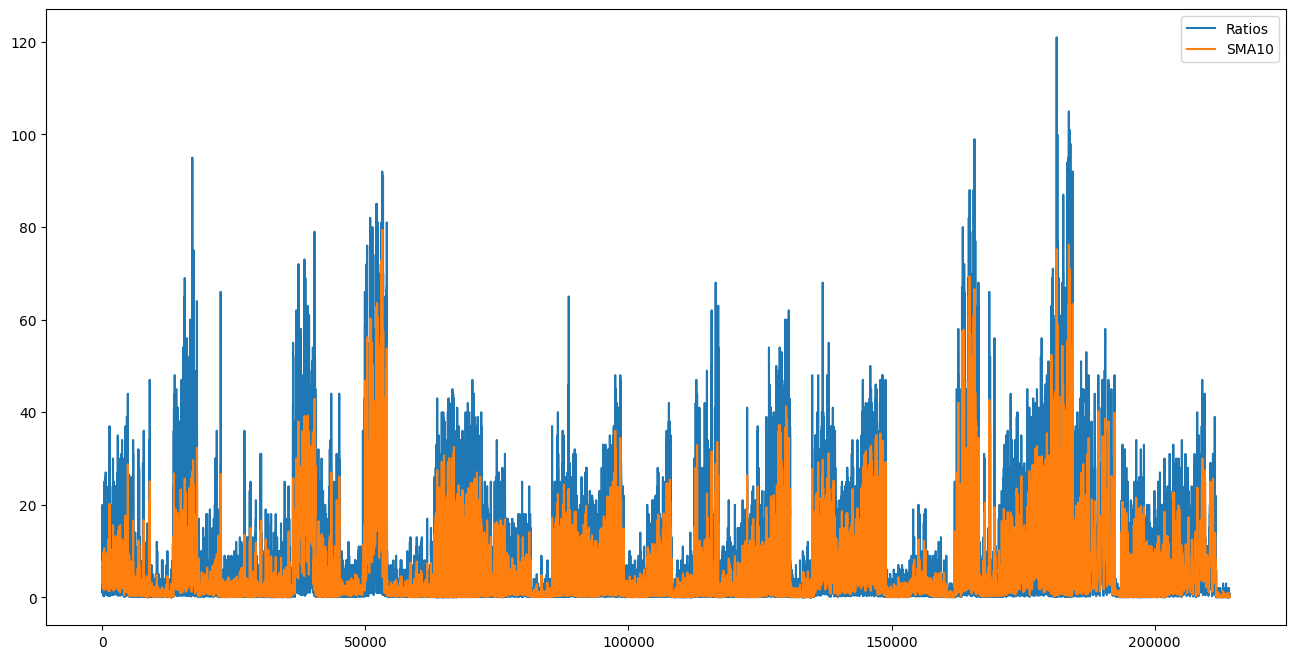

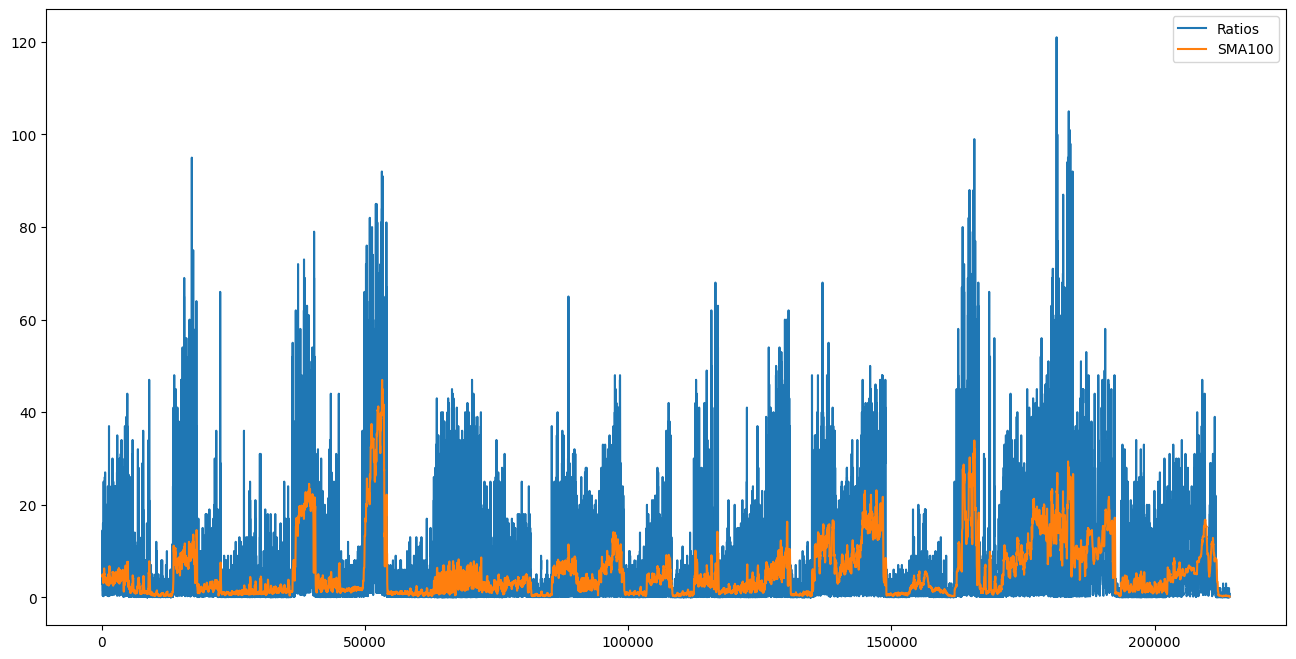

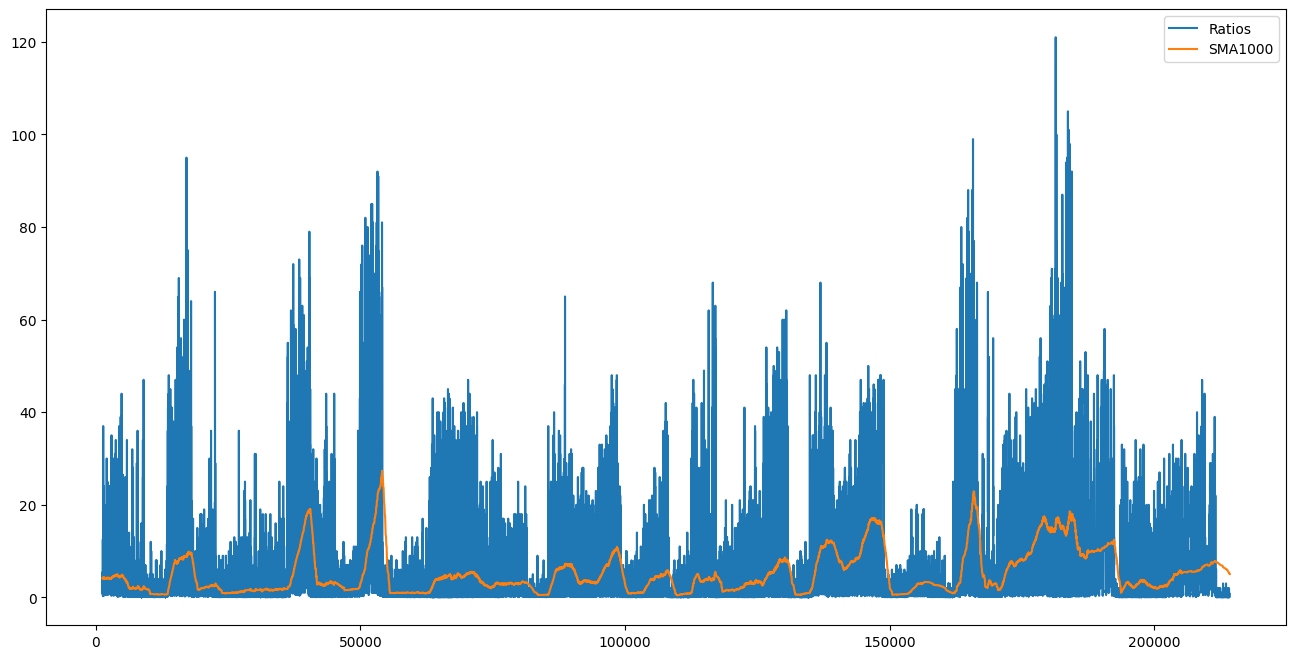

In [ ]:
mape, mse = moving_averages_ratios(ratios_jan,5)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

mape, mse = moving_averages_ratios(ratios_jan,10)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

mape, mse = moving_averages_ratios(ratios_jan,100)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

mape, mse = moving_averages_ratios(ratios_jan,1000)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

In [ ]:
#Choosing 5 as the most suitable value

    Given  2022    Ratios      SMA5       Pred   AbsError       mae  \
37      6    39  6.500000  7.960000  47.760000   8.760000  0.224615   
38      5    31  6.200000  8.840000  44.200000  13.200000  0.425806   
39      3    28  9.333333  8.706667  26.120000   1.880000  0.067143   
40     10    29  2.900000  7.686667  76.866667  47.866667  1.650575   
41      5    33  6.600000  6.306667  31.533333   1.466667  0.044444   

             se  
37    76.737600  
38   174.240000  
39     3.534400  
40  2291.217778  
41     2.151111  
Mean Absolute Percentage Error: 0.6558840652854059
Mean Square Error: 131.54817552148424
Root Mean Square Error: 11.46944530138595


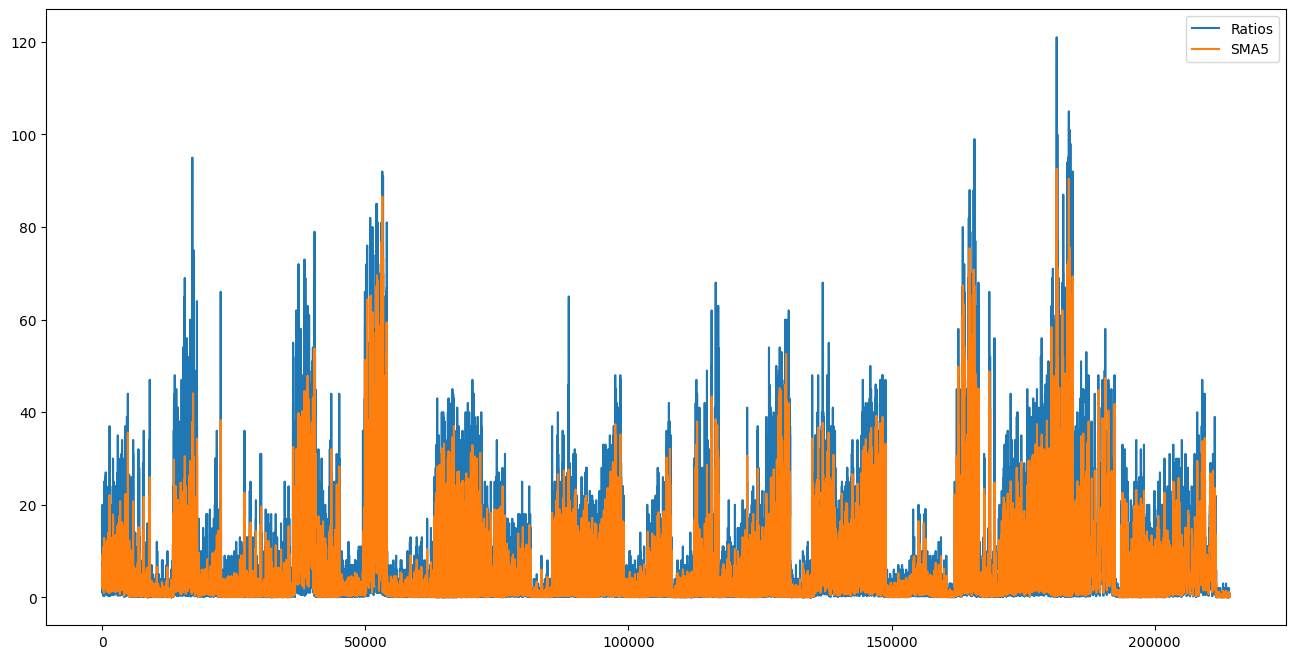

In [ ]:
mape, mse = moving_averages_ratios(ratios_jan,5)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

In [ ]:
#We can apply gradient descent to tune the hyper parameter(n), should we or too complex?

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [ ]:
def moving_averages_prev(r, n):
    ratios = r.copy()
    ratios['Pred'] = ratios['2022'].rolling(n).mean()
    ratios['AbsError'] = abs(ratios['Pred'] - ratios['2022'])
    #print(ratios.loc[ratios['Pred'] == 0])
    ratios['mae'] = ratios['AbsError']/ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['2022', 'Pred']].plot(label='Predicted',figsize=(16, 8))
    mape = ratios['mae'].mean()
    mse = ratios['se'].sum()/len(ratios['se'])
    print(ratios.head())
    #Plotting the moving averages
    
    return mape, mse

    Given  2022  Ratios  Pred     se
34      2    20    10.0  14.5  30.25
35      2    16     8.0  18.0   4.00
36      2    27    13.5  21.5  30.25
37      6    39     6.5  33.0  36.00
38      5    31     6.2  35.0  16.00
12.165446975472541
    Given  2022    Ratios  Pred      se
37      6    39  6.500000  22.2  282.24
38      5    31  6.200000  26.6   19.36
39      3    28  9.333333  28.2    0.04
40     10    29  2.900000  30.8    3.24
41      5    33  6.600000  32.0    1.00
24.29351455442876
    Given  2022    Ratios  Pred      se
42      6    33  5.500000  26.5   42.25
43      4    35  8.750000  29.1   34.81
44      5    19  3.800000  29.0  100.00
45      4    17  4.250000  29.1  146.41
46      3    17  5.666667  28.1  123.21
36.31430528169939
     Given  2022     Ratios   Pred        se
144      2    25  12.500000  14.93  101.4049
145      3    22   7.333333  15.06   48.1636
146      2    25  12.500000  15.11   97.8121
147      2    28  14.000000  15.23  163.0729
148      4    19  

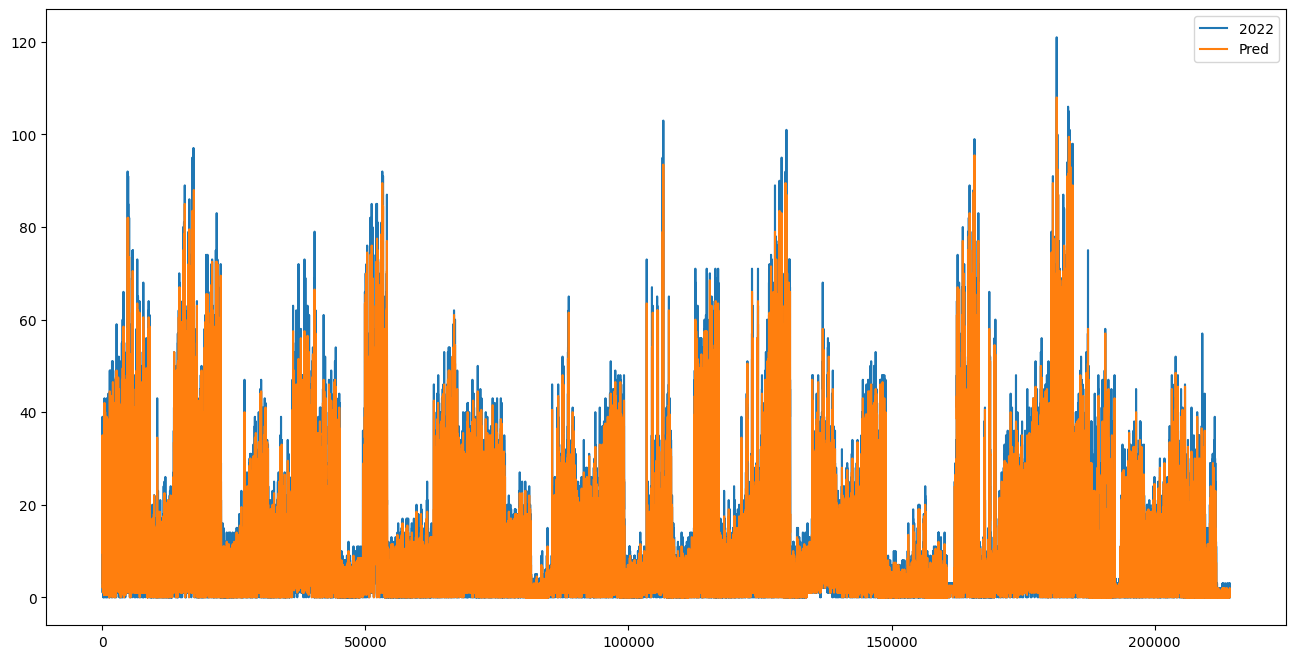

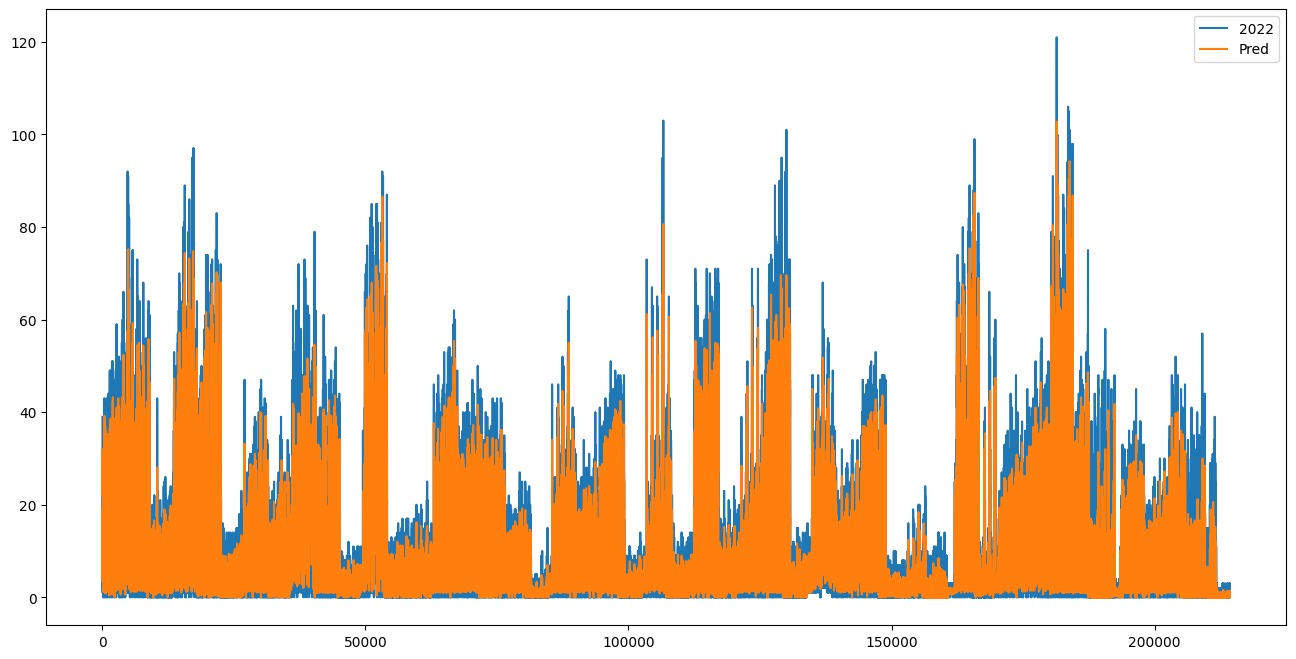

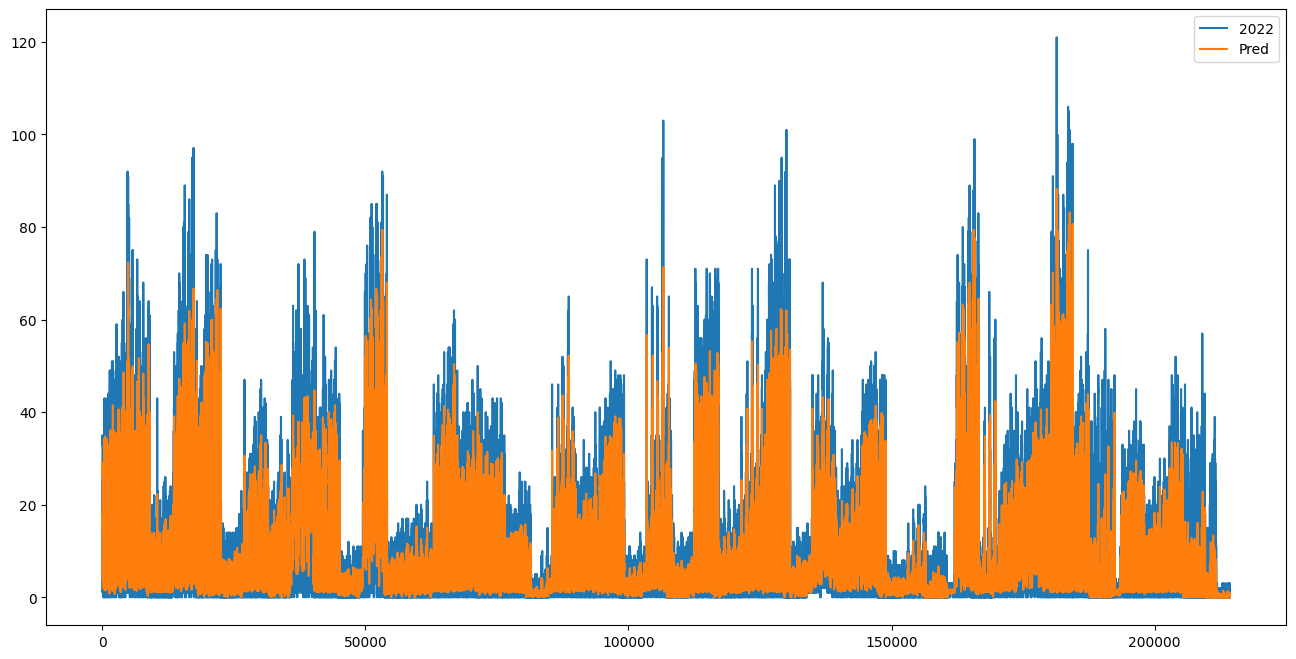

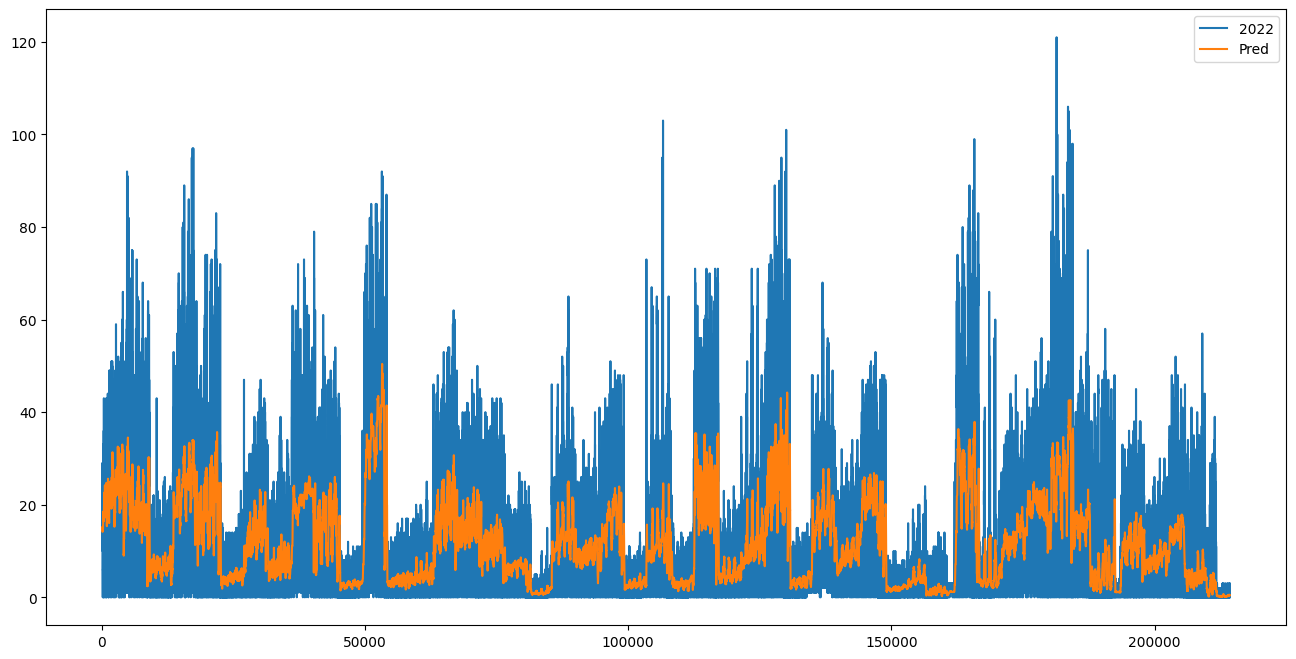

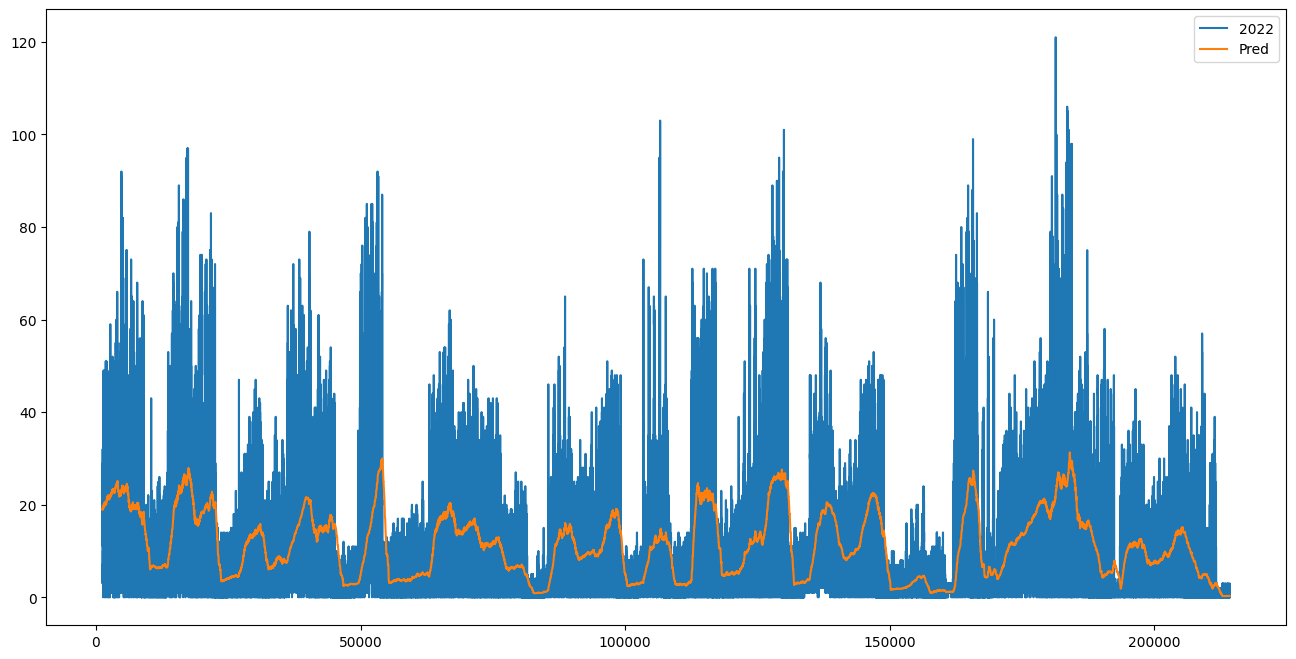

In [ ]:
print(moving_averages_prev(ratios_jan, 2))
print(moving_averages_prev(ratios_jan, 5))
print(moving_averages_prev(ratios_jan, 10))
print(moving_averages_prev(ratios_jan, 100))
print(moving_averages_prev(ratios_jan, 1000))

In [ ]:
#Moving averages for 2022 values itself is much more accurate than with the ratios
#Where window size is 2

    Given  2022  Ratios  Pred  AbsError       mae     se
34      2    20    10.0  14.5       5.5  0.275000  30.25
35      2    16     8.0  18.0       2.0  0.125000   4.00
36      2    27    13.5  21.5       5.5  0.203704  30.25
37      6    39     6.5  33.0       6.0  0.153846  36.00
38      5    31     6.2  35.0       4.0  0.129032  16.00
(0.2380303554074544, 7.809127610761851)


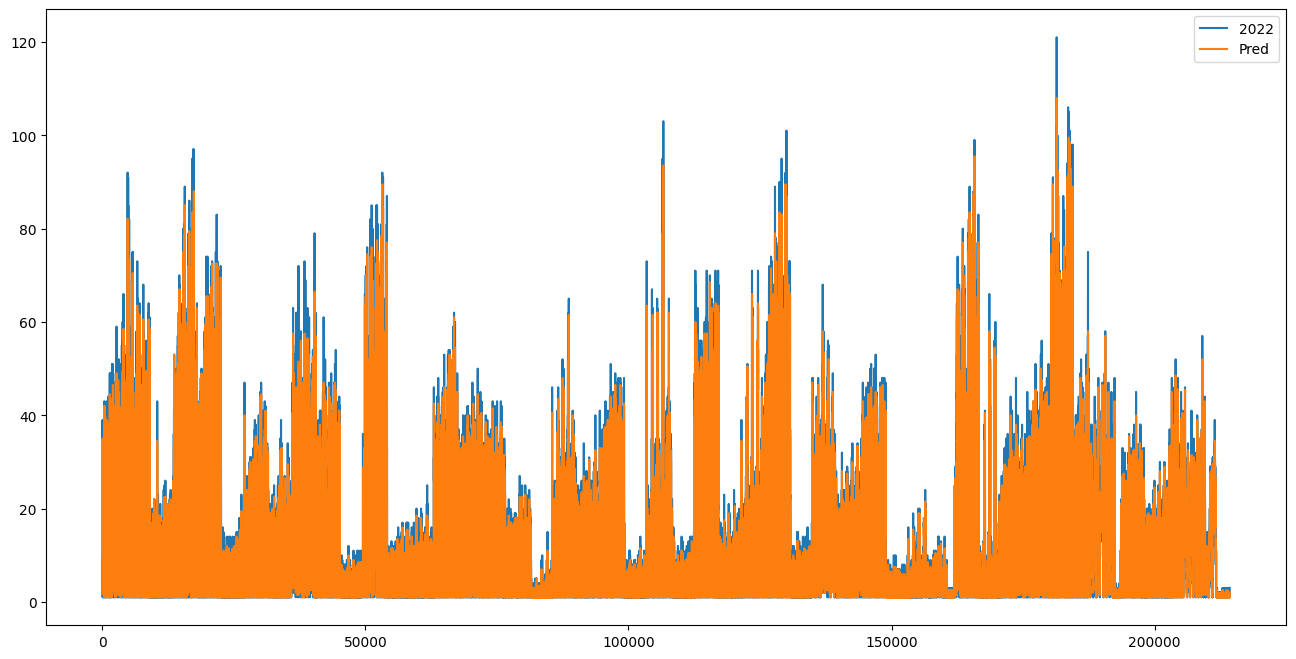

In [ ]:
print(moving_averages_prev(ratios_jan, 2))

## Exponential Moving Averages


Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [ ]:
def exponential_moving_averages_ratios(r, n):
    ratios = r.copy()
    lab = 'EWMA' + str(n)
    ratios[lab] = ratios['Ratios'].ewm(span=n).mean()
    ratios.dropna(inplace=True)
    ratios['Pred'] = ratios['2022'] * ratios[lab]
    ratios[['Ratios', lab]].plot(label='Ratios',figsize=(16, 8))
    ratios['AbsError'] = abs(ratios['Pred'] - ratios['2022'])
    #print(ratios.loc[ratios['Pred'] == 0])
    ratios['mae'] = ratios['AbsError']/ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['Ratios', lab]].plot(label='Ratios',figsize=(16, 8))
    mape = ratios['mae'].mean()
    mse = ratios['se'].sum()/len(ratios['se'])
    return mape, mse

(4.015025842534136, 118981.19219155372)
(3.9766859797442358, 102103.06264532325)
(3.910646144620163, 81533.78682517615)
(3.7472354529359975, 42481.32433692176)


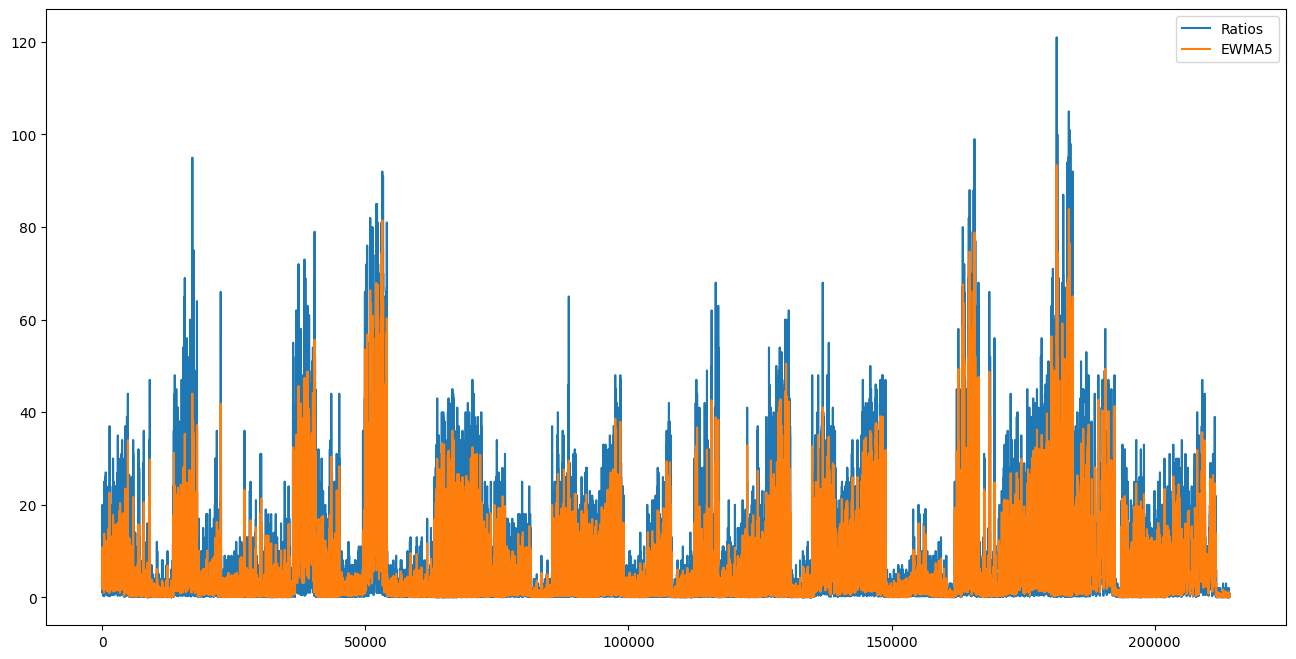

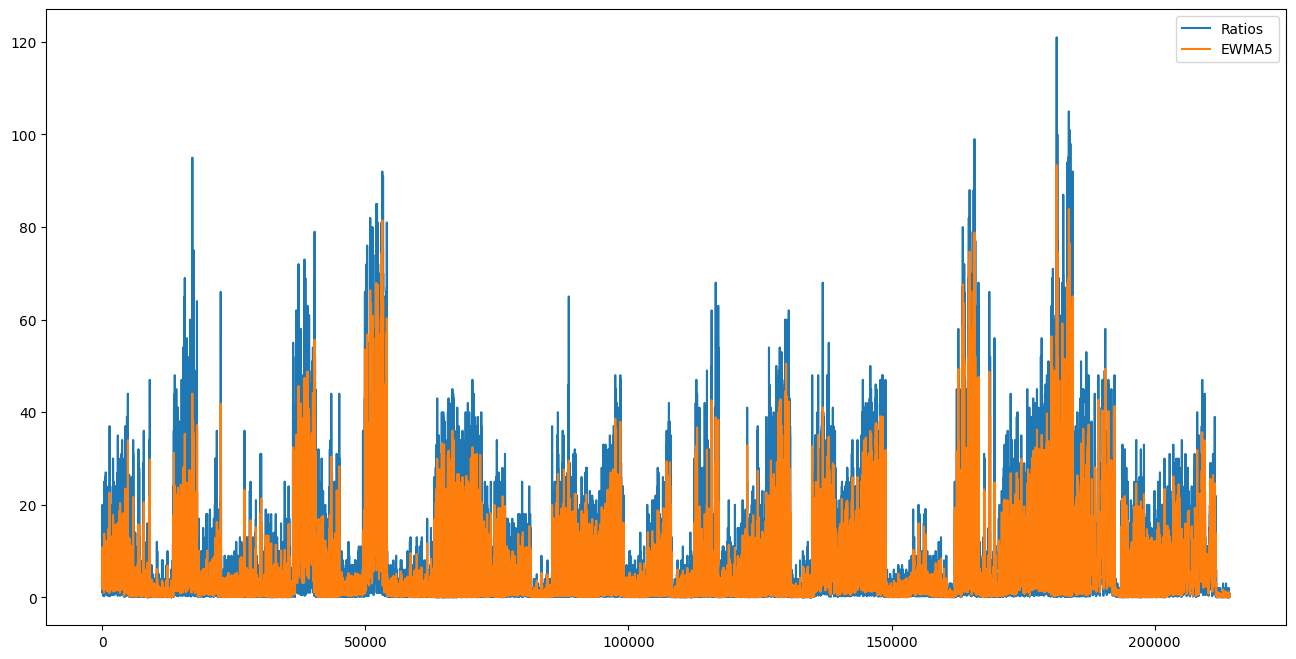

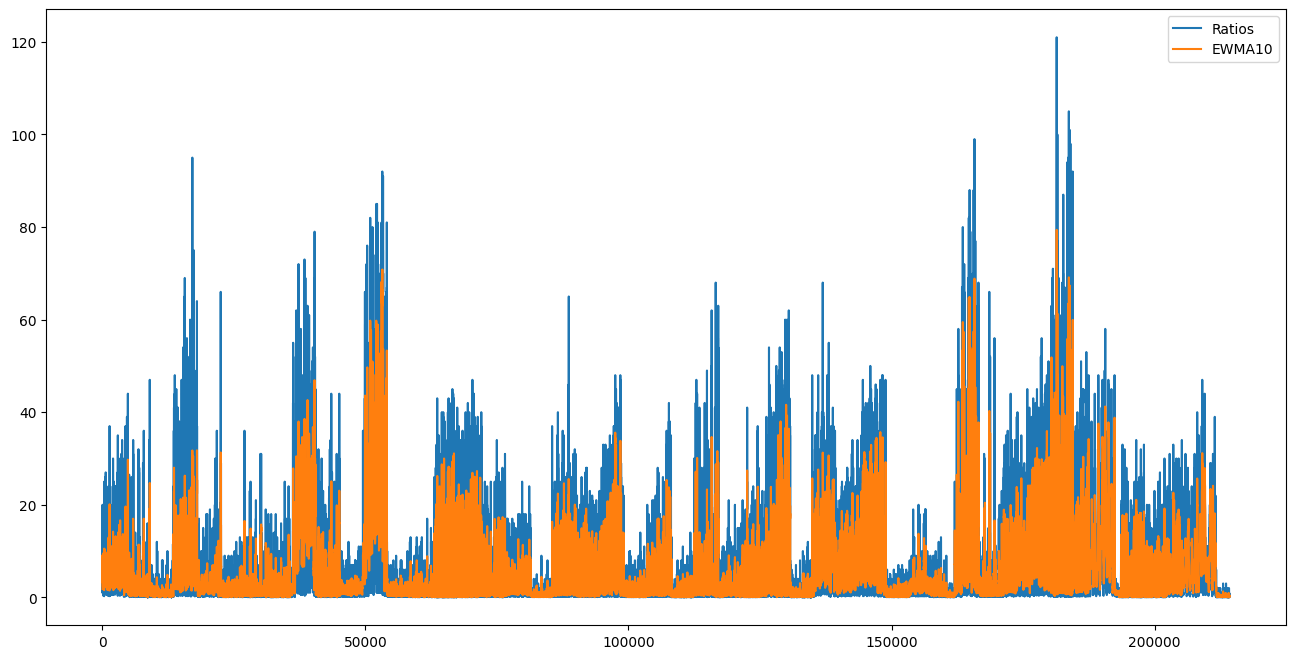

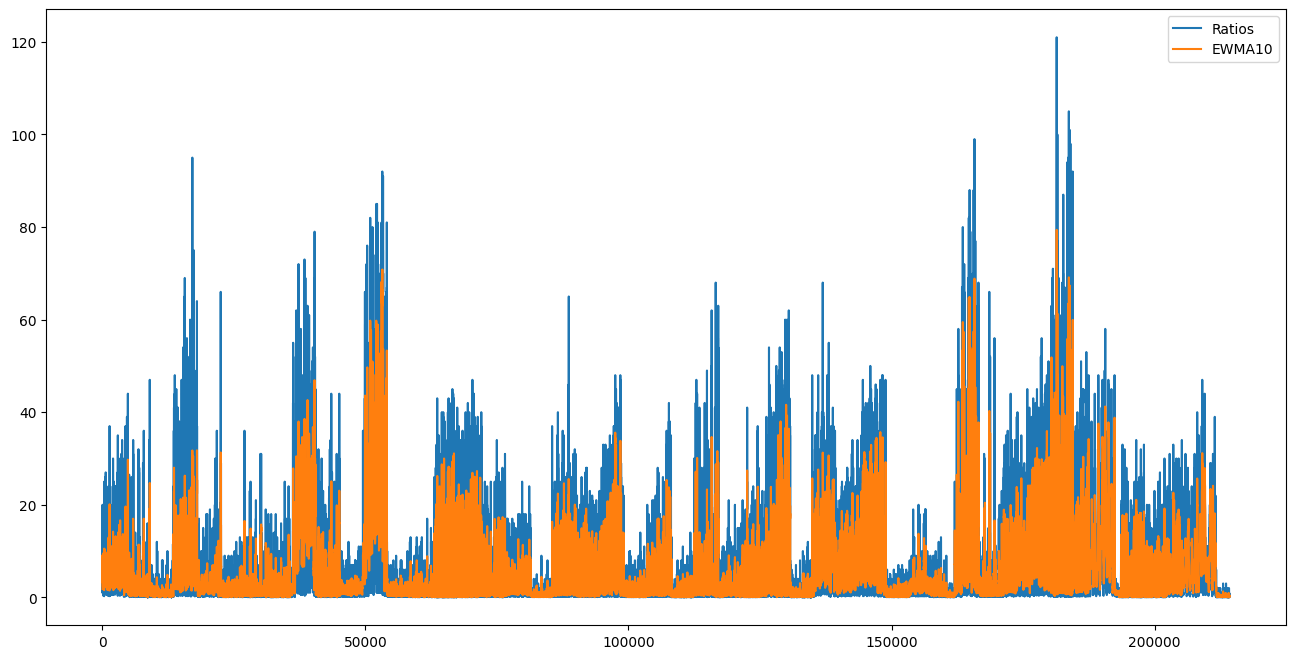

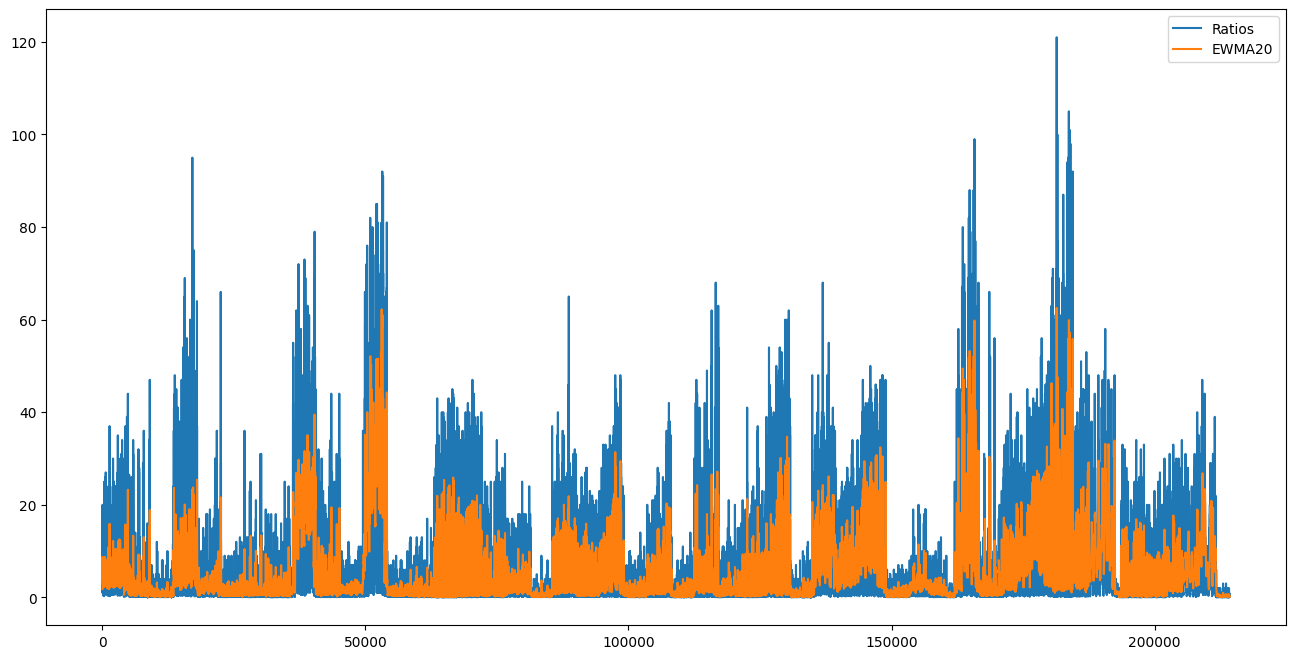

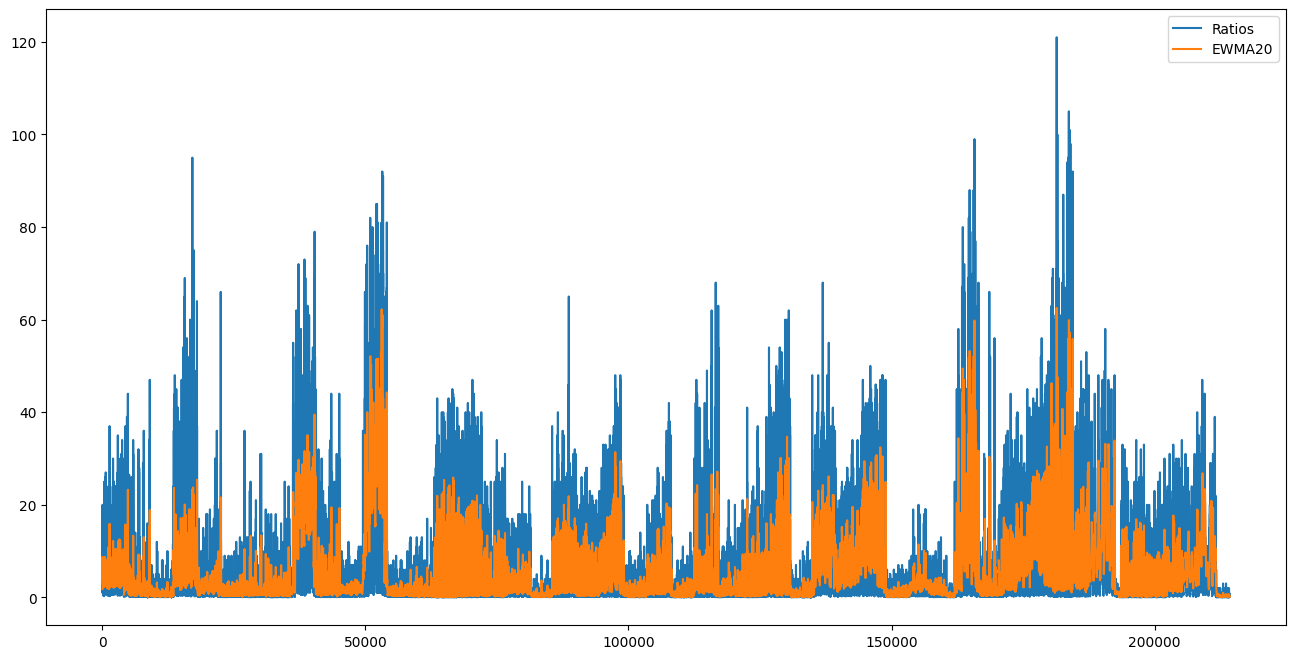

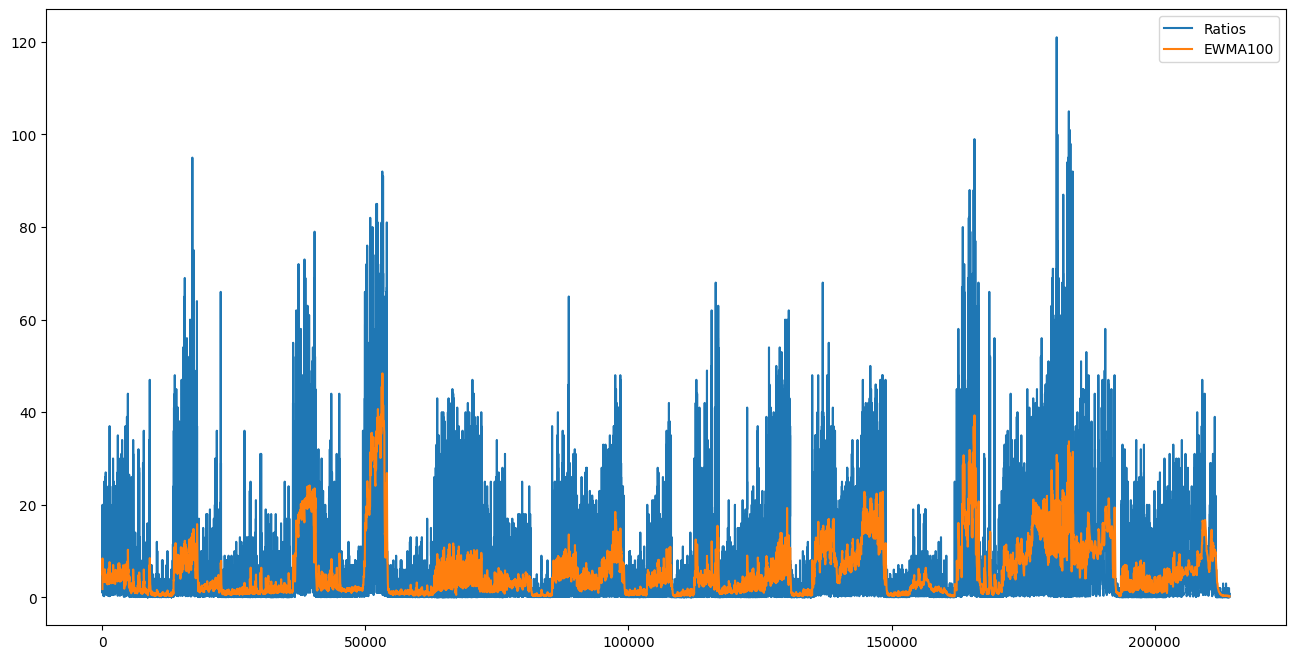

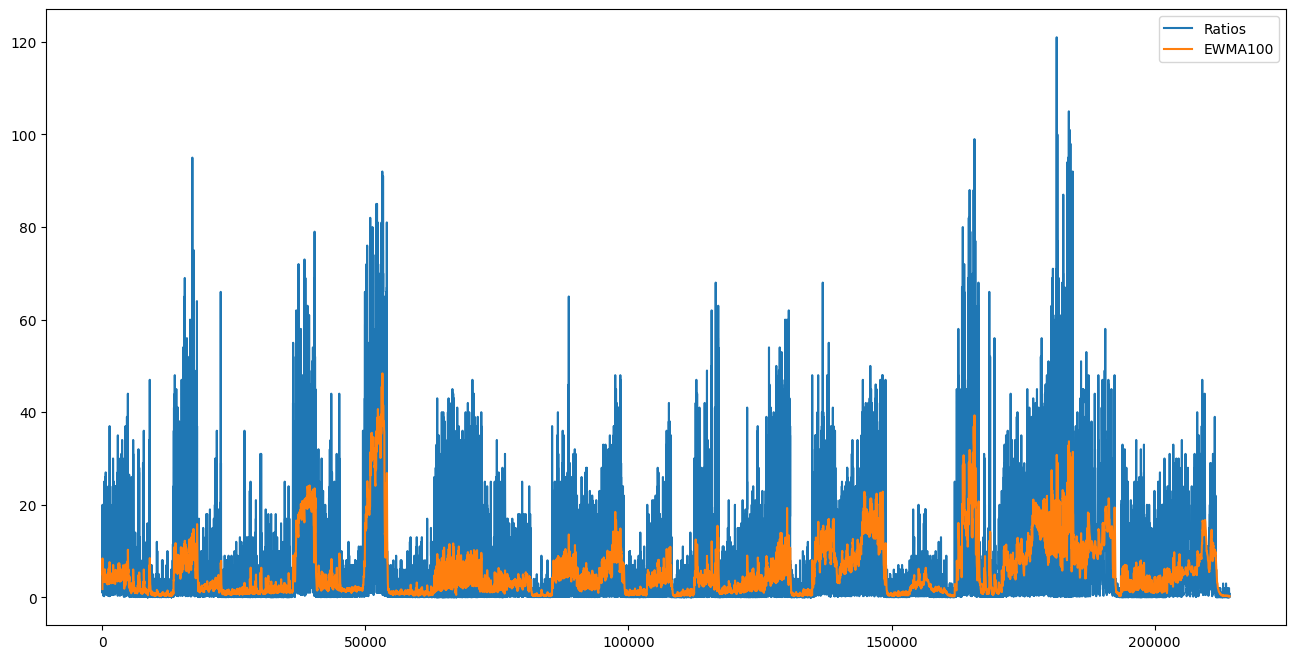

In [ ]:
print(exponential_moving_averages_ratios(ratios_jan, 5))
print(exponential_moving_averages_ratios(ratios_jan, 10))
print(exponential_moving_averages_ratios(ratios_jan, 20))
print(exponential_moving_averages_ratios(ratios_jan, 100))

In [ ]:
def exponential_moving_averages_prev(r, n):
    ratios = r.copy()
    ratios.dropna(inplace=True)
    ratios['Pred'] = ratios['2022'].ewm(span=n).mean()
    ratios[['2022', 'Pred']].plot(label='Predicted Values',figsize=(16, 8))
    ratios['AbsError'] = abs(ratios['Pred'] - ratios['2022'])
    #print(ratios.loc[ratios['Pred'] == 0])
    ratios['mae'] = ratios['AbsError']/ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['2022', 'Pred']].plot(label='Predicted',figsize=(16, 8))
    mape = ratios['mae'].mean()
    mse = ratios['se'].sum()/len(ratios['se'])
    return mape, mse

(1.57755996441175, 89.57861081160459)
(1.2908338478270869, 71.79596144721894)
(1.7338163129914523, 99.84361206668925)
(0.4826182093332002, 22.697690170336244)
(0.318442524268558, 11.897173569570413)


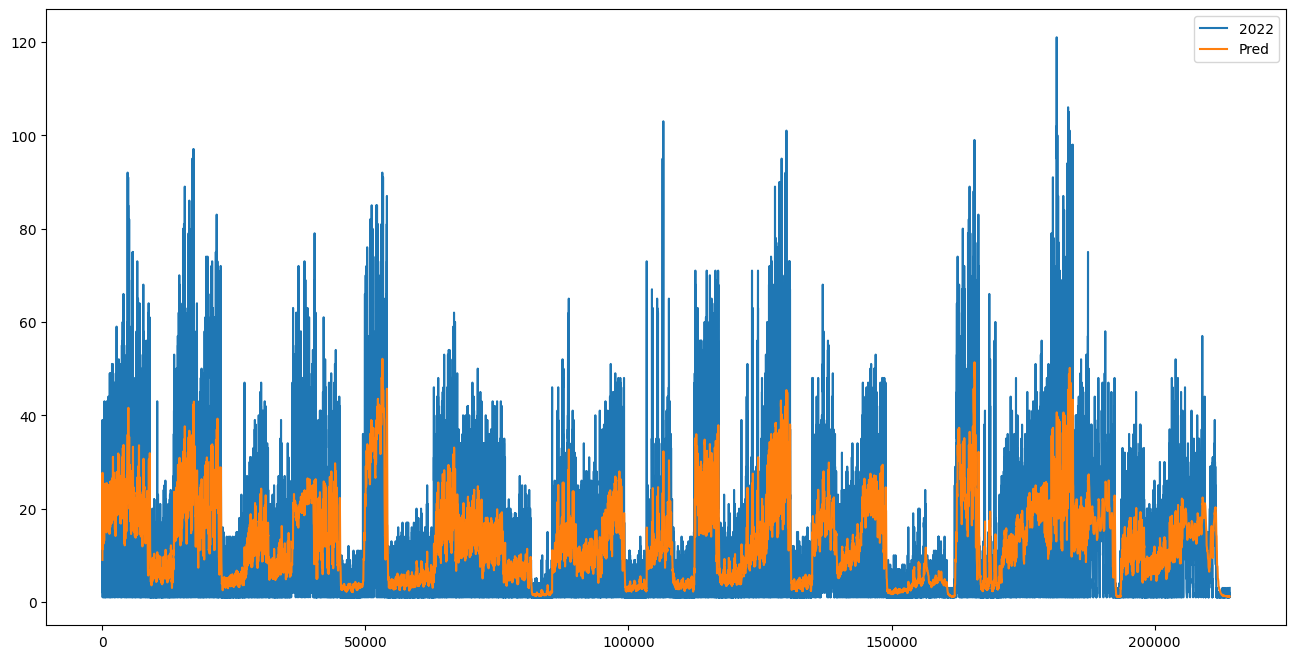

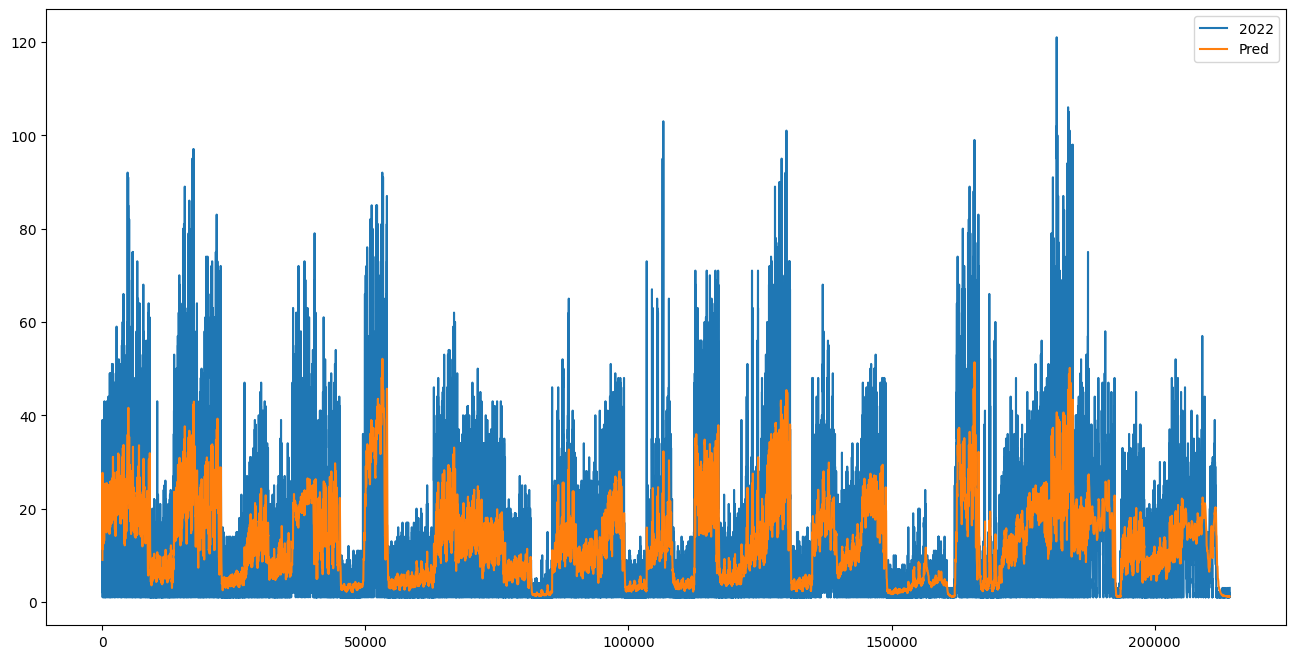

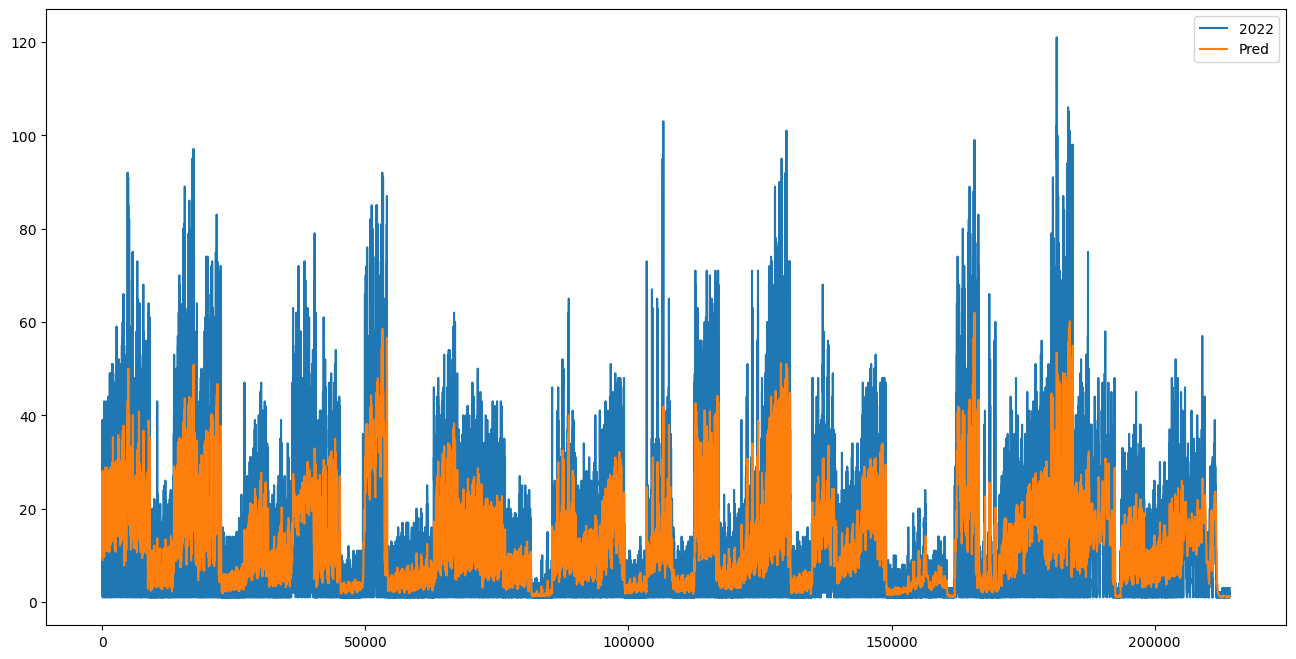

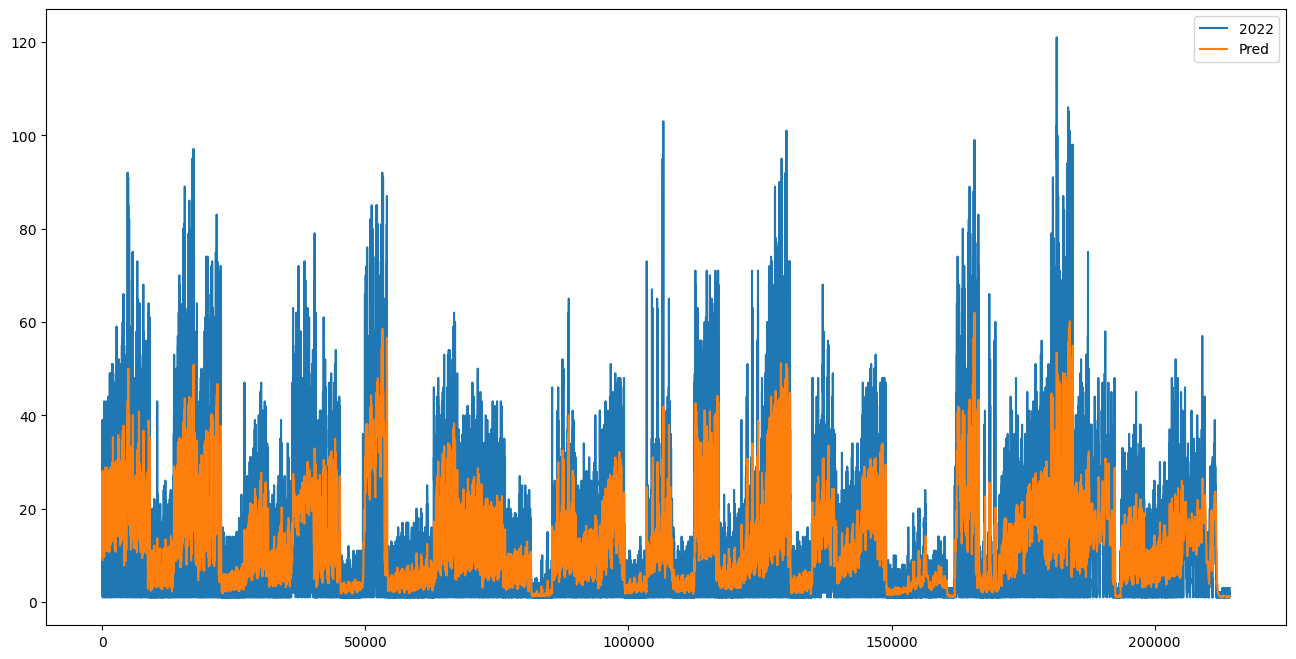

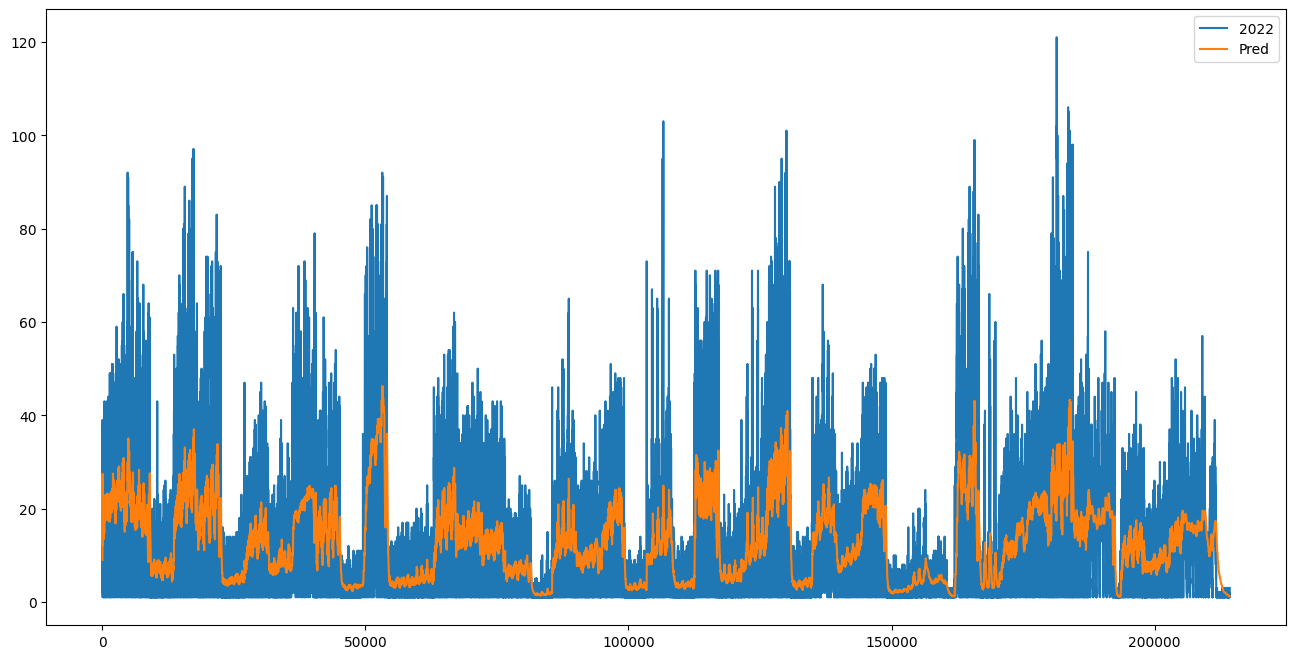

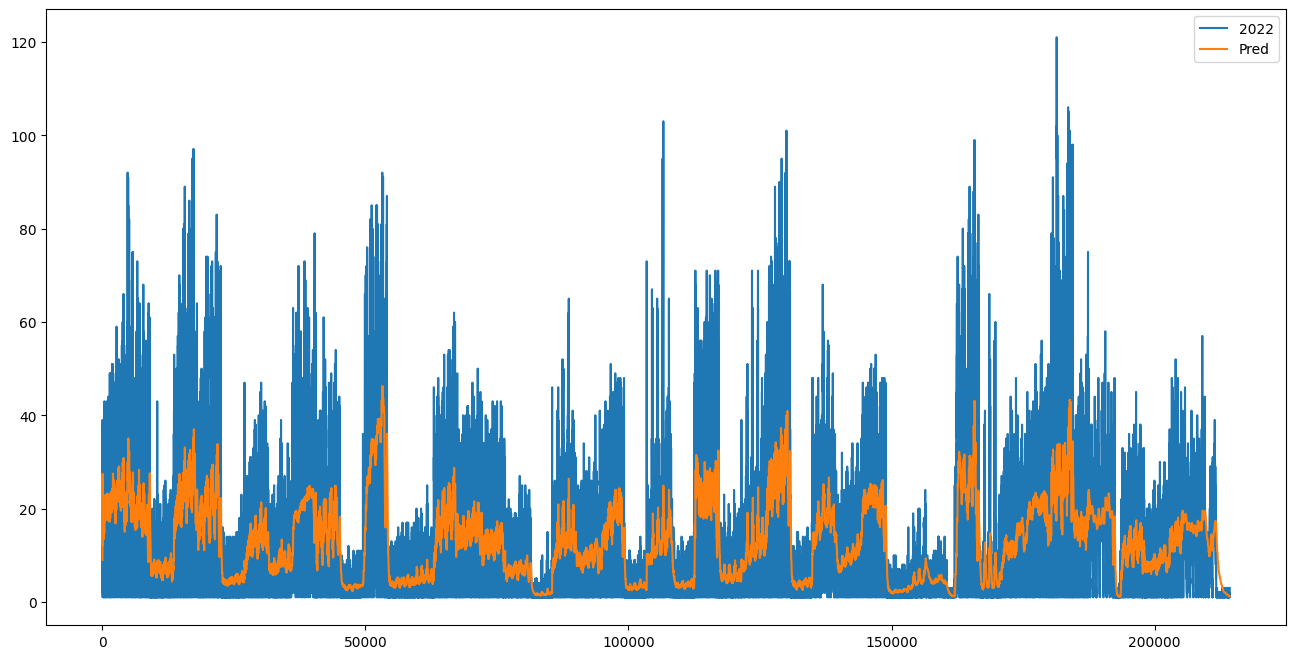

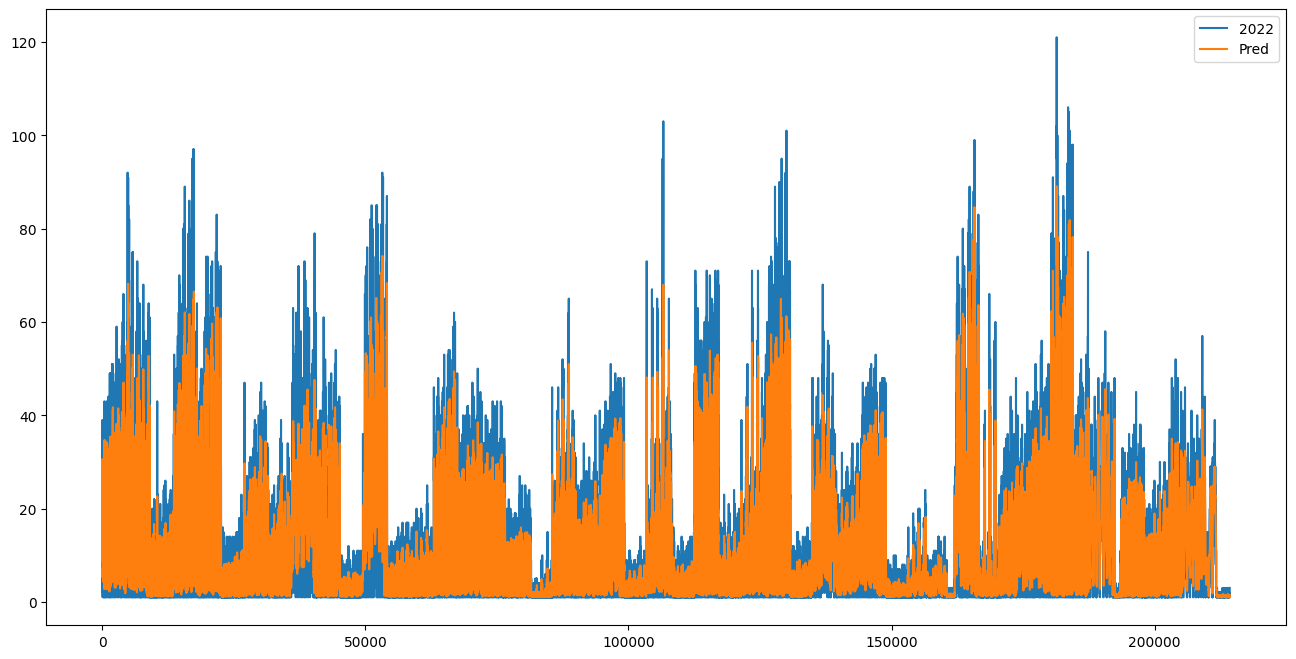

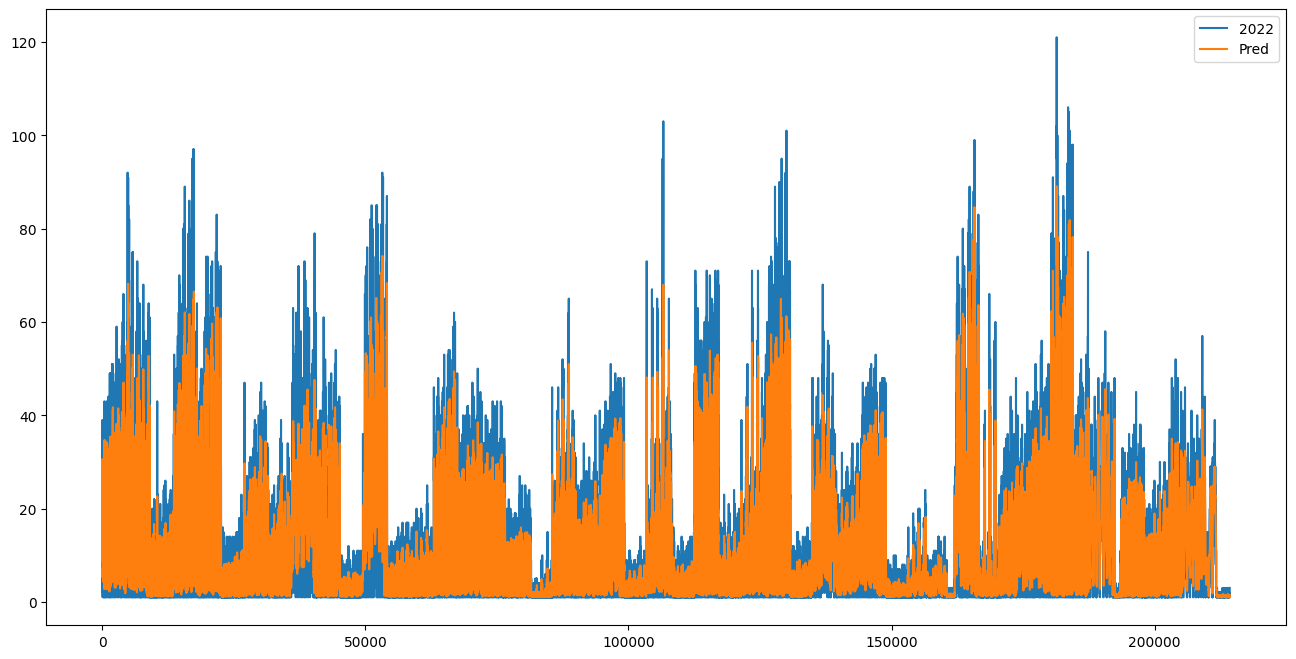

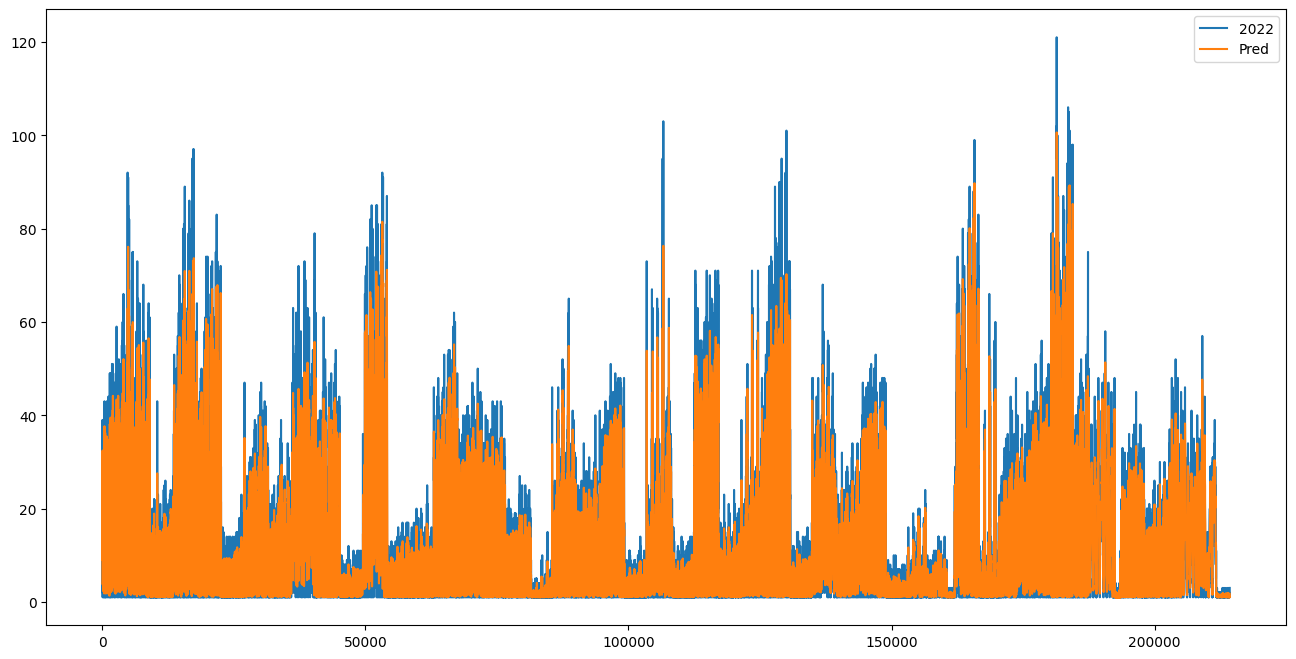

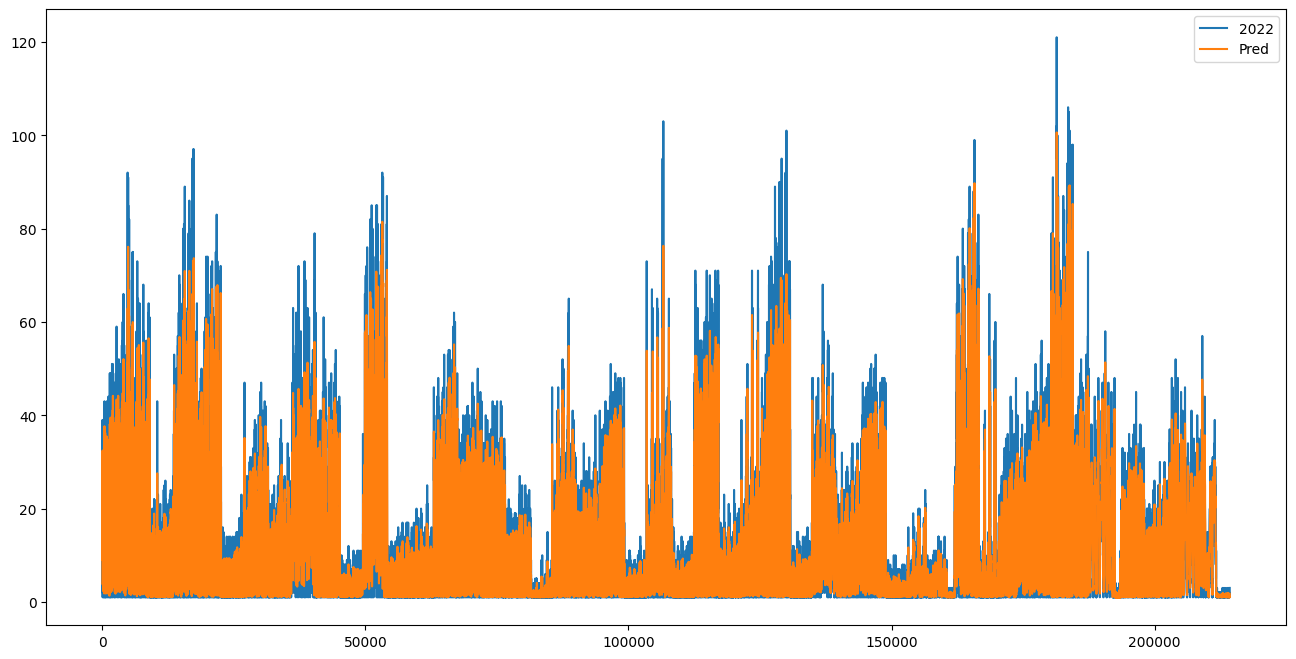

In [ ]:
print(exponential_moving_averages_prev(ratios_jan, 100))
print(exponential_moving_averages_prev(ratios_jan, 50))
print(exponential_moving_averages_prev(ratios_jan, 200))
print(exponential_moving_averages_prev(ratios_jan, 10))
print(exponential_moving_averages_prev(ratios_jan, 5))

(0.14959079491458557, 2.8868536874623194)


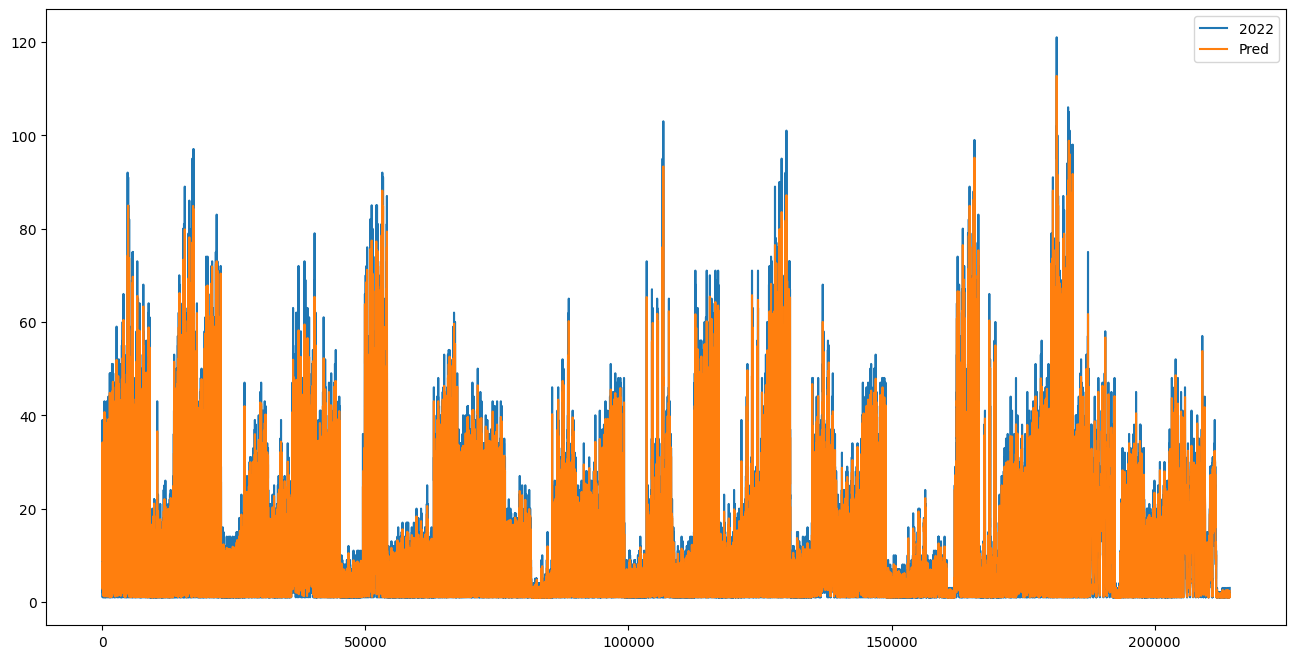

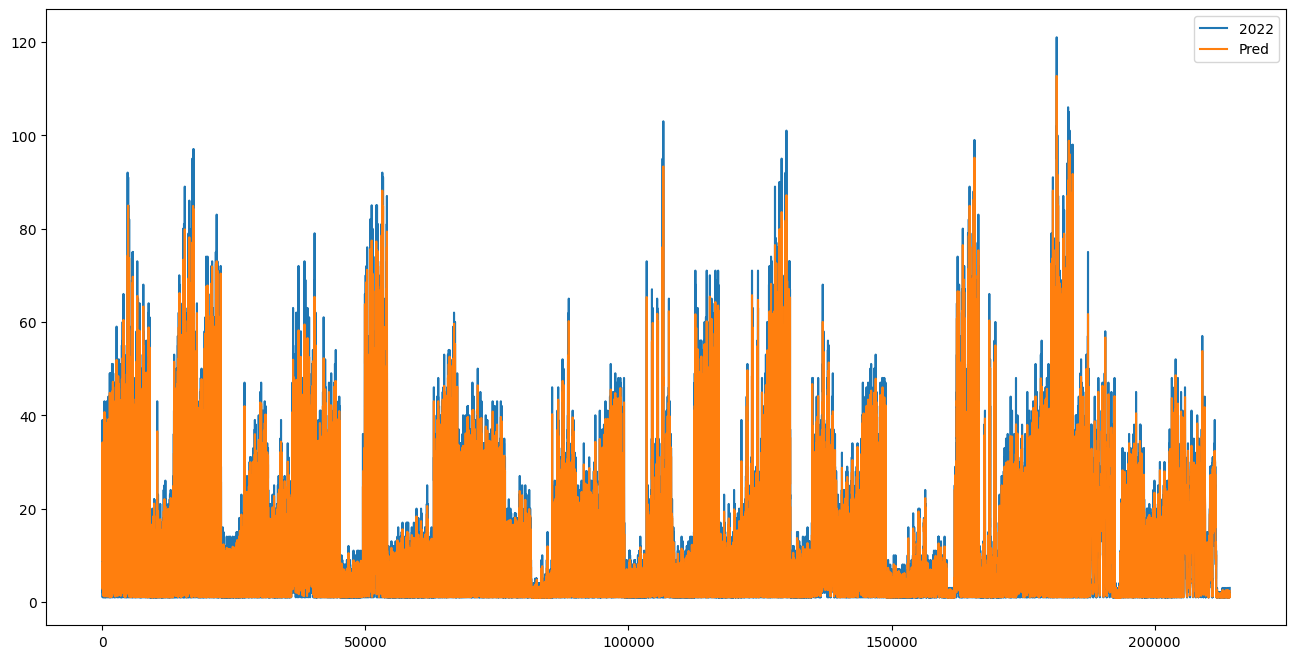

In [ ]:
print(exponential_moving_averages_prev(ratios_jan, 2))

Out of the four models we get the best result for exponential moving average when the window size is 2 and the model is based on previous values.
Therefore we set that as our bench marks

## REGRESSION

In [ ]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2021= 24*31*60/10 = 4464
# number of 10min indices for jan 2022 = 24*31*60/10 = 4464
# number of 10min indices for feb 2022 = 24*28*60/10 = 4032
# number of 10min indices for march 2022 = 24*31*60/10 = 4464
# regions_cum: it will contain 48 lists, each list will contain 4464+4032+4464 values which represents the number of pickups
# that are happened for three months in 2022 data
# print(len(regions_cum))
# 48
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 12955 for each cluster
output = []

tsne_cluster =[]
# tsne_lat will contain 13104-5=12955 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 12955times],[cent_lat 12955times], [cent_lat 12955times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=12955 times logitude of cluster center for every cluster
# Ex: [[cent_long 12955times],[cent_long 12955times], [cent_long 12955times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 12955 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0, 48):
    # tsne_lat.append([kmeans.cluster_centers_[i][0]]*12955)
    # tsne_lon.append([kmeans.cluster_centers_[i][1]]*12955)
    tsne_cluster.append([int(kmeans.cluster_centers_[0][0])]*12955)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144)) % 7+2) % 7)
                        for k in range(5, 4464+4032+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps]
                             for r in range(0, len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]


In [ ]:
len(tsne_cluster[0])*len(tsne_cluster) == tsne_feature.shape[0] == len(tsne_weekday) * \
    len(tsne_weekday[0]) == 48*12955 == len(output)*len(output[0])


True

In [ ]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1)
alpha = 0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel,
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values = []

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0, 48):
    for i in range(0, 12960):
        if i == 0:
            predicted_value = regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value = int((alpha*predicted_value) +
                              (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values = []


In [ ]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(12955*0.7))
print("size of test data :", int(12955*0.3))


size of train data : 9068
size of test data : 3886


In [ ]:
# extracting first 9068 timestamp values i.e 70% of 12955 (total timestamps) for our training data
train_features = [tsne_feature[i*12955:(12955*i+9068)] for i in range(0, 48)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(12955*(i))+9068:12955*(i+1)]
                 for i in range(0, 48)]


In [ ]:
print("Number of data clusters", len(train_features), "Number of data points in trian data", len(
    train_features[0]), "Each data point contains", len(train_features[0][0]), "features")
print("Number of data clusters", len(train_features), "Number of data points in test data",
      len(test_features[0]), "Each data point contains", len(test_features[0][0]), "features")


Number of data clusters 48 Number of data points in trian data 9068 Each data point contains 5 features
Number of data clusters 48 Number of data points in test data 3887 Each data point contains 5 features


In [ ]:
# extracting first 9068 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_cluster = [i[:9068] for i in tsne_cluster]
tsne_train_flat_weekday = [i[:9068] for i in tsne_weekday]
tsne_train_flat_output = [i[:9068] for i in output]
tsne_train_flat_exp_avg = [i[:9068] for i in predict_list]


In [ ]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_cluster = [i[9068:] for i in tsne_cluster]
tsne_test_flat_weekday = [i[9068:] for i in tsne_weekday]
tsne_test_flat_output = [i[9068:] for i in output]
tsne_test_flat_exp_avg = [i[9068:] for i in predict_list]


In [ ]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0, 48):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0, 48):
    test_new_features.extend(test_features[i])


In [ ]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_cluster = sum(tsne_train_flat_cluster, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg, [])


In [ ]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_cluster = sum(tsne_test_flat_cluster, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg, [])


In [ ]:
# Preparing the data frame for our train data
columns = ['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
df_train['cluster'] = tsne_train_cluster
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)


(435264, 8)


In [ ]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['cluster'] = tsne_test_cluster
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)


(186576, 8)


In [ ]:
df_test.head()


ft_5  ft_4  ft_3  ft_2  ft_1  cluster  weekday  exp_avg
0    72    86    92    75    84       90        2       82
1    86    92    75    84    80       90        2       80
2    92    75    84    80    80       90        2       80
3    75    84    80    80    86       90        2       84
4    84    80    80    86    61       90        2       67

## LINEAR REGRESSION

In [ ]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]


## USING RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2,
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0,
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor(
    max_features='sqrt', min_samples_leaf=4, min_samples_split=3, n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [ ]:
# Predicting on test data using our trained random forest model

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]


In [ ]:
# feature importances based on analysis using random forest
print(df_train.columns)
print(regr1.feature_importances_)


Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'cluster', 'weekday',
       'exp_avg'],
      dtype='object')
[0.08860348 0.14055328 0.11226433 0.15313356 0.20727662 0.
 0.00829601 0.28987271]


## Using XgBoost Regressor

In [ ]:
df_train.dtypes

ft_5       int64
ft_4       int64
ft_3       int64
ft_2       int64
ft_1       int64
cluster    int64
weekday    int64
exp_avg    int64
dtype: object

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear',
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1,
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None,
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    reg_alpha=200, reg_lambda=200,
    colsample_bytree=0.8, nthread=4)
x_model.fit(df_train, tsne_train_output)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', ...)

In [ ]:
# predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]


In [ ]:
# feature importances
x_model.get_booster().get_score(importance_type='weight')

{'ft_5': 1167.0,
 'ft_4': 1054.0,
 'ft_3': 1105.0,
 'ft_2': 1077.0,
 'ft_1': 1113.0,
 'weekday': 431.0,
 'exp_avg': 904.0}

## Calculating the error metric values for various models

In [ ]:
train_mape = []
test_mape = []

train_mape.append((mean_absolute_error(tsne_train_output,
                  df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,
                  df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, rndf_train_predictions)
                   )/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions)
                   )/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions)
                   )/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output,
                 df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output,
                 df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions)
                  )/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions)
                  )/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions)
                  )/(sum(tsne_test_output)/len(tsne_test_output)))


In [ ]:
print("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print("--------------------------------------------------------------------------------------------------------")
print("Baseline Model -                             Train: ",
      train_mape[0], "      Test: ", test_mape[0])
print("Exponential Averages Forecasting -           Train: ",
      train_mape[1], "      Test: ", test_mape[1])
print("Linear Regression -                         Train: ",
      train_mape[3], "      Test: ", test_mape[3])
print("Random Forest Regression -                   Train: ",
      train_mape[2], "     Test: ", test_mape[2])


Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.3361469456559528       Test:  0.3169612561780867
Exponential Averages Forecasting -           Train:  0.3068668407607024       Test:  0.2896952497883749
Linear Regression -                         Train:  0.30153147519538287       Test:  0.2819631389753874
Random Forest Regression -                   Train:  0.2517873767826953      Test:  0.2847109779724515


## Error Metric Matrix

In [ ]:
print("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print("--------------------------------------------------------------------------------------------------------")
print("Baseline Model -                             Train: ",
      train_mape[0], "      Test: ", test_mape[0])
print("Exponential Averages Forecasting -           Train: ",
      train_mape[1], "      Test: ", test_mape[1])
print("Linear Regression -                         Train: ",
      train_mape[4], "      Test: ", test_mape[4])
print("Random Forest Regression -                   Train: ",
      train_mape[2], "     Test: ", test_mape[2])
print("XgBoost Regression -                         Train: ",
      train_mape[3], "      Test: ", test_mape[3])
print("--------------------------------------------------------------------------------------------------------")


Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.3361469456559528       Test:  0.3169612561780867
Exponential Averages Forecasting -           Train:  0.3068668407607024       Test:  0.2896952497883749
Linear Regression -                         Train:  0.3044716291411172       Test:  0.28245634084665533
Random Forest Regression -                   Train:  0.2517873767826953      Test:  0.2847109779724515
XgBoost Regression -                         Train:  0.30153147519538287       Test:  0.2819631389753874
--------------------------------------------------------------------------------------------------------
